In [16]:
import math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import seaborn as sns

from utils import *
from IPython.display import JSON

%config InlineBackend.figure_format = 'retina'

font_dirs = ['/Library/Fonts/']
font_files = mpl.font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    mpl.font_manager.fontManager.addfont(font_file)
mpl.rcParams['font.family'] = 'Barlow'
sns.set(font='Barlow')

palette = color = ['#223E5C','#5EACA3','#F1D670','#DC6046']
palette_cb = ['#364B9A','#6EA6CD','#C2E4EF','#EAECCC','#FEDA8B','#F67E4B','#A50026']
palette_cb_long = ['#364B9A','#4A7BB7','#6EA6CD','#98CAE1','#C2E4EF','#EAECCC','#FEDA8B','#FDB366','#F67E4B','#DD3D2D','#A50026']

attendance_suffix_name = {True:'InPresence',False:'NoPresence'}

In [17]:
# Select which age groups to use (NOTE: specific contacts and respondent data will be loaded, see cell below.)
age_groups = 5

# Loading Italian population data as of January 2022
ag = pd.read_csv('data_in/age_gender.csv')
ag['age'] = ag['Età'].apply(lambda x: x.split(' ')[0])
ag = ag[(ag['Sesso']=='totale')&(ag['age']!='totale')&(ag['Territorio']=='Italia')]
ag = ag.groupby('age')['Value'].sum().reset_index()
ag = ag.astype({'age':int, 'Value':int}).sort_values('age').reset_index(drop=True)
ag[f'pop_{age_groups}'] = pd.cut(ag['age'], 
                                 bins=[i for i in range(0,75,age_groups)]+[150], 
                                 labels=[f'{i}-{i+age_groups-1}' for i in range(0,70,age_groups)]+['70+'], 
                                 right=True)
population_vector = ag.groupby(f'pop_{age_groups}', observed=False)['Value'].sum()


In [18]:
# Load respondents' and contacts' data
cs = pd.read_csv(f"data_out/contacts_prol_prop_{age_groups}y_agegroups.csv")
ri = pd.read_csv(f"data_out/participants_rich_{age_groups}y_agegroups.csv")

ri[f'part_age_group_pop_{age_groups}'] = ri[f'part_age_group_{age_groups}'].map(population_vector.to_dict())
cs[f'part_age_group_pop_{age_groups}'] = cs[f'part_age_group_{age_groups}'].map(population_vector.to_dict())
cs[f'cnt_age_group_pop_{age_groups}'] = cs[f'cnt_age_group_{age_groups}'].map(population_vector.to_dict())

ri['attendance'] = ri['presence_work'].map({'In-person work': True, np.nan:False, 'No work':False, 'Remote work':False}) | ri['presence_school'].map({'In-person attendance': True, np.nan:False, 'No attendance':False, 'Remote attendance':False})


########################################################################
### Selecting contacts and respondents of interest 
########################################################################
contactToPlot = cs[cs['is_soft']!=True].copy() # The number of contacts an individual had is computed as the non-overlapping sum of the direct contacts and the indirect contacts minus the indoor direct contacts
contactToPlot = contactToPlot.merge(ri[['part_id']],on='part_id', how='right')
respondentToPlot = ri.copy()

## 1. Contact Matrices

In [19]:
###########################
savedir = 'data_out/matrices/bootstrap/'
bootstrap_iterations = 1000

###########################
order_col = 'part_age'
group_col = f'part_age_group_{age_groups}'     # selected age_group of interest
group_pop = f'part_age_group_pop_{age_groups}' # population vector mapped to each respondent age_group


index_pop = respondentToPlot.drop_duplicates(group_col).sort_values(order_col).set_index(group_col)[group_pop].to_dict()
group_loc = contactToPlot[[group_col,order_col,group_pop]].dropna().drop_duplicates().sort_values(order_col).loc[:,group_col].dropna().unique()

### Total contacts

In [20]:
q, m = bootstrap_contact_matrices(respondentToPlot, respondentToPlot, contactToPlot, group_col, group_pop, order_col, 
                                  bootstrap=bootstrap_iterations, bootstrap_dir=f'{savedir}bootstrap_age_group{"_"+str(age_groups) if age_groups !=5 else ""}_total/', index_NA=index_pop)

### Data PREPARATION
### averaging Qs and average contacts for each bootstrap iteration
q1g = pd.concat([q[coli] for coli in q.columns])
dsx1 = pd.concat([pd.DataFrame(index=m[0].index,columns=m[0].columns, data=mi).sum() for mi in m])
### Averaging bootstrapped matrices
tmp1 = pd.DataFrame(index=m[0].index,columns=m[0].columns, data=np.array([mi.values for mi in m]).mean(0))


input_2A = [tmp1.copy(), q1g.copy(), dsx1.copy()]

#######################################################################

Bootstrapping ... 1000 / 1000	

In [21]:
#######################################################################
#######################################################################
# Compute c. mat. from rinfo and contacts for subsample of population #
#######################################################################
#### Set "attendance" to "True" to get "in presence" work/school matrices, set to "False" to get "remote/not-in-person/no workers" matrices
# If "attendance is None" get total matrices
attendance = True
if attendance: suffix = 'In-person'
else:          suffix = 'Not-in-person'
#######################################################################
subset_group = None
subset_value = None
sens=12
round_notes = 1

#### Select target respondent and their contacts
if group_pop not in respondentToPlot.columns:
    respondentToPlot[group_pop] = respondentToPlot[group_col].map(contactToPlot[[group_col,group_pop]].drop_duplicates().set_index(group_col).to_dict()[group_pop])
######## Select subset of respondents ! ########
if not attendance is None: rsi = respondentToPlot[(respondentToPlot['attendance']==attendance)].copy()  
else:                      rsi = respondentToPlot.copy()
################################################
cts = contactToPlot[contactToPlot['part_id'].isin(rsi['part_id'])].copy()
gl = cts[[group_col,order_col,group_pop]].dropna().drop_duplicates().sort_values(order_col).loc[:,group_col].dropna().unique()
#######################################################################
q, m = bootstrap_contact_matrices(respondentToPlot,rsi, cts, group_col, group_pop, order_col, group_loc, bootstrap=bootstrap_iterations, 
                                  bootstrap_dir=f'{savedir}bootstrap_age_group{"_"+str(age_groups) if age_groups !=5 else ""}_total_{attendance_suffix_name[attendance]}/', index_NA=index_pop)
### averaging Qs and average contacts for each bootstrap iteration
q1g = pd.concat([q[coli] for coli in q.columns]).loc[gl]
dsx2 = pd.concat([pd.DataFrame(index=m[0].index,columns=m[0].columns, data=mi).sum() for mi in m]).loc[gl]
### Averaging bootstrapped matrices
tmp2 = pd.DataFrame(index=m[0].index,columns=m[0].columns, data=np.array([mi.values for mi in m]).mean(0))

input_2B = [tmp2.copy(), q1g.copy(), dsx2.copy()]

Bootstrapping ... 1000 / 1000	

In [22]:
#######################################################################
# Compute c. mat. from rinfo and contacts for subsample of population #
#######################################################################
#### Set "attendance" to "True" to get "in presence" work/school matrices, set to "False" to get "remote/not-in-person/no workers" matrices
# If "attendance is None" get total matrices
attendance = False
if attendance: suffix = 'In-person'
else:          suffix = 'Not-in-person'
#######################################################################
subset_group = None
subset_value = None
sens=12
round_notes = 1

#### Select target respondent and their contacts
if group_pop not in respondentToPlot.columns:
    respondentToPlot[group_pop] = respondentToPlot[group_col].map(contactToPlot[[group_col,group_pop]].drop_duplicates().set_index(group_col).to_dict()[group_pop])
######## Select subset of respondents ! ########
if not attendance is None: rsi = respondentToPlot[(respondentToPlot['attendance']==attendance)].copy()  
else:                      rsi = respondentToPlot.copy()
################################################
cts = contactToPlot[contactToPlot['part_id'].isin(rsi['part_id'])].copy()
gl = cts[[group_col,order_col,group_pop]].dropna().drop_duplicates().sort_values(order_col).loc[:,group_col].dropna().unique()
#######################################################################
q, m = bootstrap_contact_matrices(respondentToPlot,rsi, cts, group_col, group_pop, order_col, group_loc, bootstrap=bootstrap_iterations, 
                                  bootstrap_dir=f'{savedir}bootstrap_age_group{"_"+str(age_groups) if age_groups !=5 else ""}_total_{attendance_suffix_name[attendance]}/', index_NA=index_pop)
### averaging Qs and average contacts for each bootstrap iteration
q1g = pd.concat([q[coli] for coli in q.columns]).loc[gl]
dsx3 = pd.concat([pd.DataFrame(index=m[0].index,columns=m[0].columns, data=mi).sum() for mi in m]).loc[gl]
### Averaging bootstrapped matrices
tmp3 = pd.DataFrame(index=m[0].index,columns=m[0].columns, data=np.array([mi.values for mi in m]).mean(0))

input_2C = [tmp3.copy(), q1g.copy(), dsx3.copy()]
# #######################################################################

Bootstrapping ... 1000 / 1000	

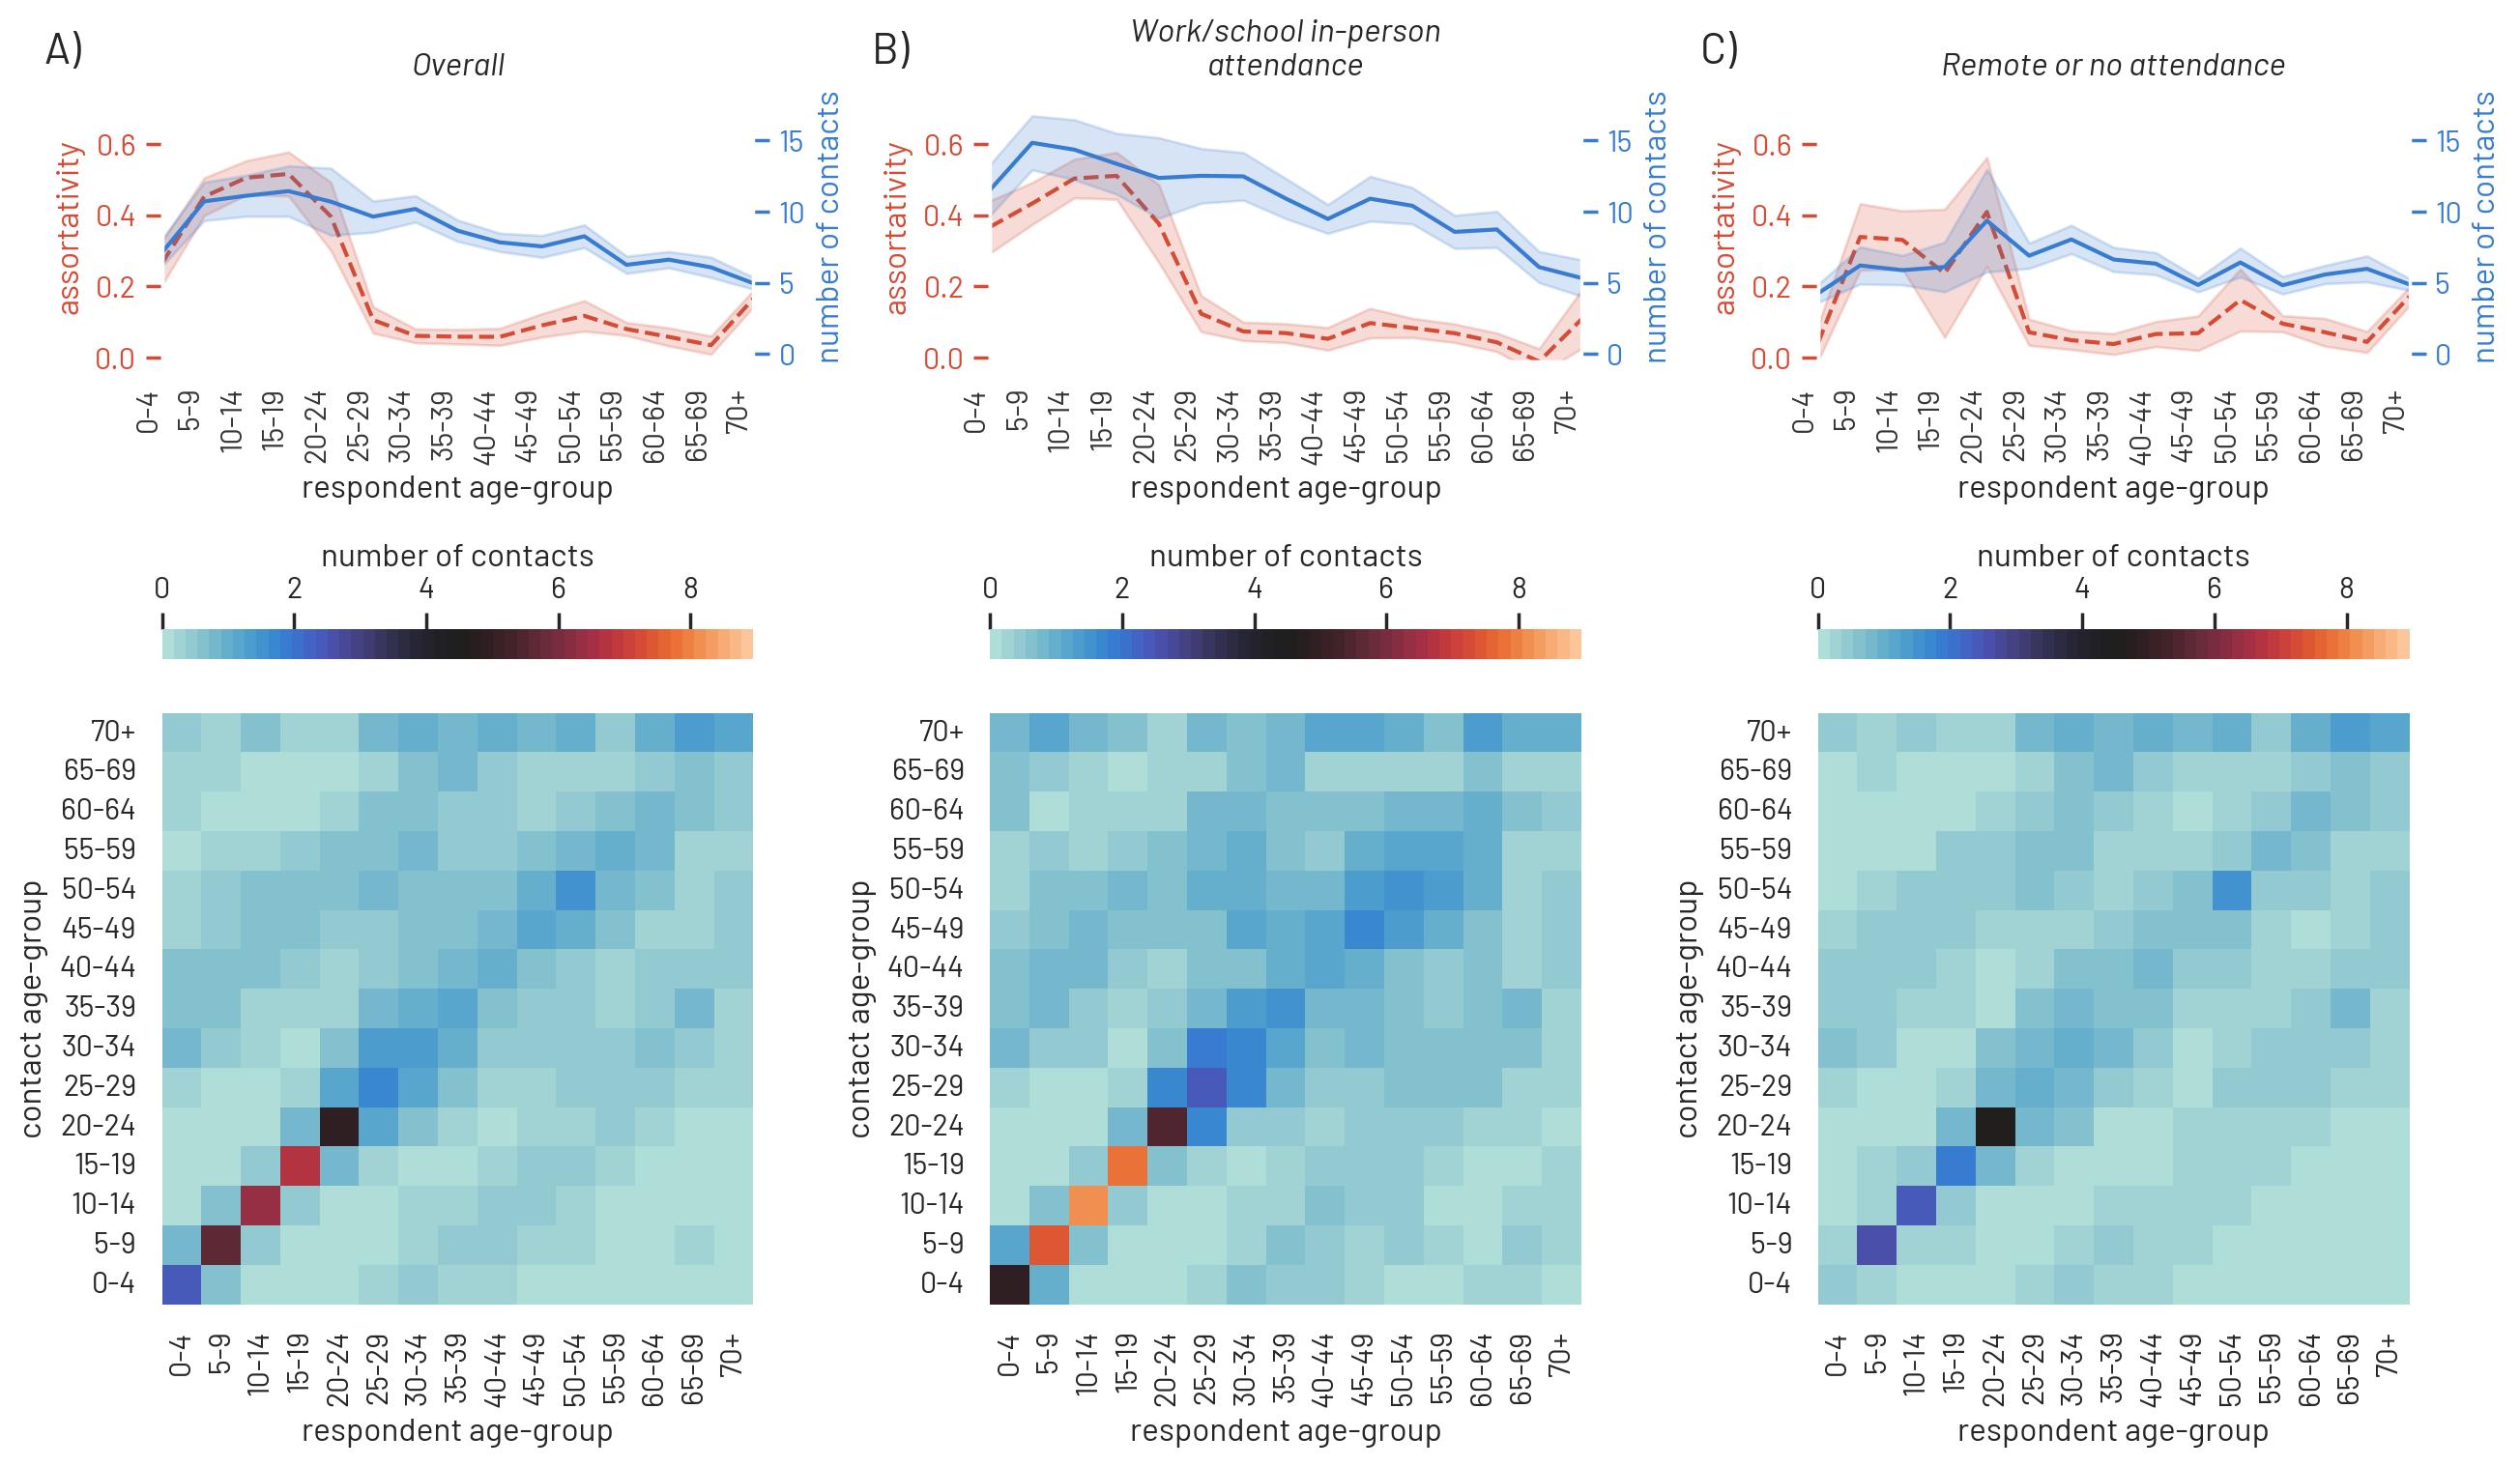

In [23]:
######### FIGURE drawing ##########
fsize=14
A_ylims = [(-.01,0.75),(-0.5,18.5)]
C_lims = (0,8.95)
fig1, ax = plt.subplot_mosaic([['A','B','C'],['D','E','F']], gridspec_kw={'height_ratios': [0.2,.8]}, figsize=(15,10))
set_plot_style(ax['A'], legend=False,xlims=[0,14])
set_plot_style(ax['B'], legend=False,xlims=[0,14])
set_plot_style(ax['C'], legend=False,xlims=[0,14])

tmpA, qgA, dsxA = input_2A
tmpB, qgB, dsxB = input_2B
tmpC, qgC, dsxC = input_2C

[ax['A'],ax['D']] = plot_contact_matrix(tmpA, qgA, dsxA, fig_title='Overall', Q=False, A_ylims=A_ylims, C_lims=C_lims, annotations=False, square=True, axs=[ax['A'],ax['D']])
[ax['B'],ax['E']] = plot_contact_matrix(tmpB, qgB, dsxB, fig_title='Work/school in-person\nattendance', Q=False, A_ylims=A_ylims, C_lims=C_lims, annotations=False, square=True, axs=[ax['B'],ax['E']])
[ax['C'],ax['F']] = plot_contact_matrix(tmpC, qgC, dsxC, fig_title='Remote or no attendance', Q=False, A_ylims=A_ylims, C_lims=C_lims, annotations=False, square=True, axs=[ax['C'],ax['F']])

for panel_up, panel_down in [('A','D'),('B','E'),('C','F')]:
    ax[panel_up].text(x=-.2,y=1.1, s=panel_up+')', fontweight ='normal', fontsize=16, transform=ax[panel_up].transAxes)
    # ax[panel_down].text(x=-.2,y=1.25, s=panel_down+')', fontweight ='normal', fontsize=16, transform=ax[panel_down].transAxes)
    ax[panel_up].set_facecolor('white')
    ax[panel_up].grid(False)
    
plt.subplots_adjust(wspace=0.4,hspace=0.2)
fig1.savefig(f'figures_out/figure2_age_group{"_"+str(age_groups) if age_groups !=5 else ""}_overall.pdf', bbox_inches='tight')

In [70]:
# print("Total",round(tmpA.sum().sum(),4))
# print("InPresence",round(tmpB.sum().sum(),4))
# print("NoPresence",round(tmpC.sum().sum(),4))

Total 127.2546
InPresence 161.8849
NoPresence 92.2576


### SI Matrix Figures

#### Direct contacts only

In [24]:
# DIRECT contacts only
contactToPlot = cs[cs['is_soft'].isna()].copy() # The number of contacts an individual had is computed as the direct contacts only
contactToPlot = contactToPlot.merge(ri[['part_id']],on='part_id', how='right')
respondentToPlot = ri.copy()

############## Computing Matrices
q, m = bootstrap_contact_matrices(respondentToPlot, respondentToPlot, contactToPlot, group_col, group_pop, order_col, bootstrap=bootstrap_iterations, 
                                  bootstrap_dir=f'{savedir}bootstrap_age_group{"_"+str(age_groups) if age_groups !=5 else ""}_direct_total/', index_NA=index_pop)

### Data PREPARATION
### averaging Qs and average contacts for each bootstrap iteration
q1g = pd.concat([q[coli] for coli in q.columns])
dsx1 = pd.concat([pd.DataFrame(index=m[0].index,columns=m[0].columns, data=mi).sum() for mi in m])
### Averaging bootstrapped matrices
tmp1 = pd.DataFrame(index=m[0].index,columns=m[0].columns, data=np.array([mi.values for mi in m]).mean(0))


input_2A_dir = [tmp1.copy(), q1g.copy(), dsx1.copy()]

#######################################################################
#######################################################################

# Compute c. mat. from rinfo and contacts for subsample of population #
#######################################################################
#### Set "attendance" to "True" to get "in presence" work/school matrices, set to "False" to get "remote/not-in-person/no workers" matrices
# If "attendance is None" get total matrices
attendance = True
if attendance: suffix = 'In-person'
else:          suffix = 'Not-in-person'
#######################################################################
subset_group = None
subset_value = None
sens=12
round_notes = 1

#### Select target respondent and their contacts
if group_pop not in respondentToPlot.columns:
    respondentToPlot[group_pop] = respondentToPlot[group_col].map(contactToPlot[[group_col,group_pop]].drop_duplicates().set_index(group_col).to_dict()[group_pop])
######## Select subset of respondents ! ########
if not attendance is None: rsi = respondentToPlot[(respondentToPlot['attendance']==attendance)].copy()  
else:                      rsi = respondentToPlot.copy()
################################################
cts = contactToPlot[contactToPlot['part_id'].isin(rsi['part_id'])].copy()
gl = cts[[group_col,order_col,group_pop]].dropna().drop_duplicates().sort_values(order_col).loc[:,group_col].dropna().unique()
#######################################################################
q, m = bootstrap_contact_matrices(respondentToPlot,rsi, cts, group_col, group_pop, order_col, group_loc, bootstrap=bootstrap_iterations, 
                                  bootstrap_dir=f'{savedir}bootstrap_age_group{"_"+str(age_groups) if age_groups !=5 else ""}_direct_total_{attendance_suffix_name[attendance]}/', index_NA=index_pop)
### averaging Qs and average contacts for each bootstrap iteration
q1g = pd.concat([q[coli] for coli in q.columns]).loc[gl]
dsx1 = pd.concat([pd.DataFrame(index=m[0].index,columns=m[0].columns, data=mi).sum() for mi in m]).loc[gl]
### Averaging bootstrapped matrices
tmp1 = pd.DataFrame(index=m[0].index,columns=m[0].columns, data=np.array([mi.values for mi in m]).mean(0))

input_2B_dir = [tmp1.copy(), q1g.copy(), dsx1.copy()]

#######################################################################
# Compute c. mat. from rinfo and contacts for subsample of population #
#######################################################################
#### Set "attendance" to "True" to get "in presence" work/school matrices, set to "False" to get "remote/not-in-person/no workers" matrices
# If "attendance is None" get total matrices
attendance = False
if attendance: suffix = 'In-person'
else:          suffix = 'Not-in-person'
#######################################################################
subset_group = None
subset_value = None
sens=12
round_notes = 1

#### Select target respondent and their contacts
if group_pop not in respondentToPlot.columns:
    respondentToPlot[group_pop] = respondentToPlot[group_col].map(contactToPlot[[group_col,group_pop]].drop_duplicates().set_index(group_col).to_dict()[group_pop])
######## Select subset of respondents ! ########
if not attendance is None: rsi = respondentToPlot[(respondentToPlot['attendance']==attendance)].copy()  
else:                      rsi = respondentToPlot.copy()
################################################
cts = contactToPlot[contactToPlot['part_id'].isin(rsi['part_id'])].copy()
gl = cts[[group_col,order_col,group_pop]].dropna().drop_duplicates().sort_values(order_col).loc[:,group_col].dropna().unique()
#######################################################################
q, m = bootstrap_contact_matrices(respondentToPlot,rsi, cts, group_col, group_pop, order_col, group_loc, bootstrap=bootstrap_iterations, 
                                  bootstrap_dir=f'{savedir}bootstrap_age_group{"_"+str(age_groups) if age_groups !=5 else ""}_direct_total_{attendance_suffix_name[attendance]}/', index_NA=index_pop)
### averaging Qs and average contacts for each bootstrap iteration
q1g = pd.concat([q[coli] for coli in q.columns]).loc[gl]
dsx1 = pd.concat([pd.DataFrame(index=m[0].index,columns=m[0].columns, data=mi).sum() for mi in m]).loc[gl]
### Averaging bootstrapped matrices
tmp1 = pd.DataFrame(index=m[0].index,columns=m[0].columns, data=np.array([mi.values for mi in m]).mean(0))

input_2C_dir = [tmp1.copy(), q1g.copy(), dsx1.copy()]
# #######################################################################


Bootstrapping ... 1000 / 1000	

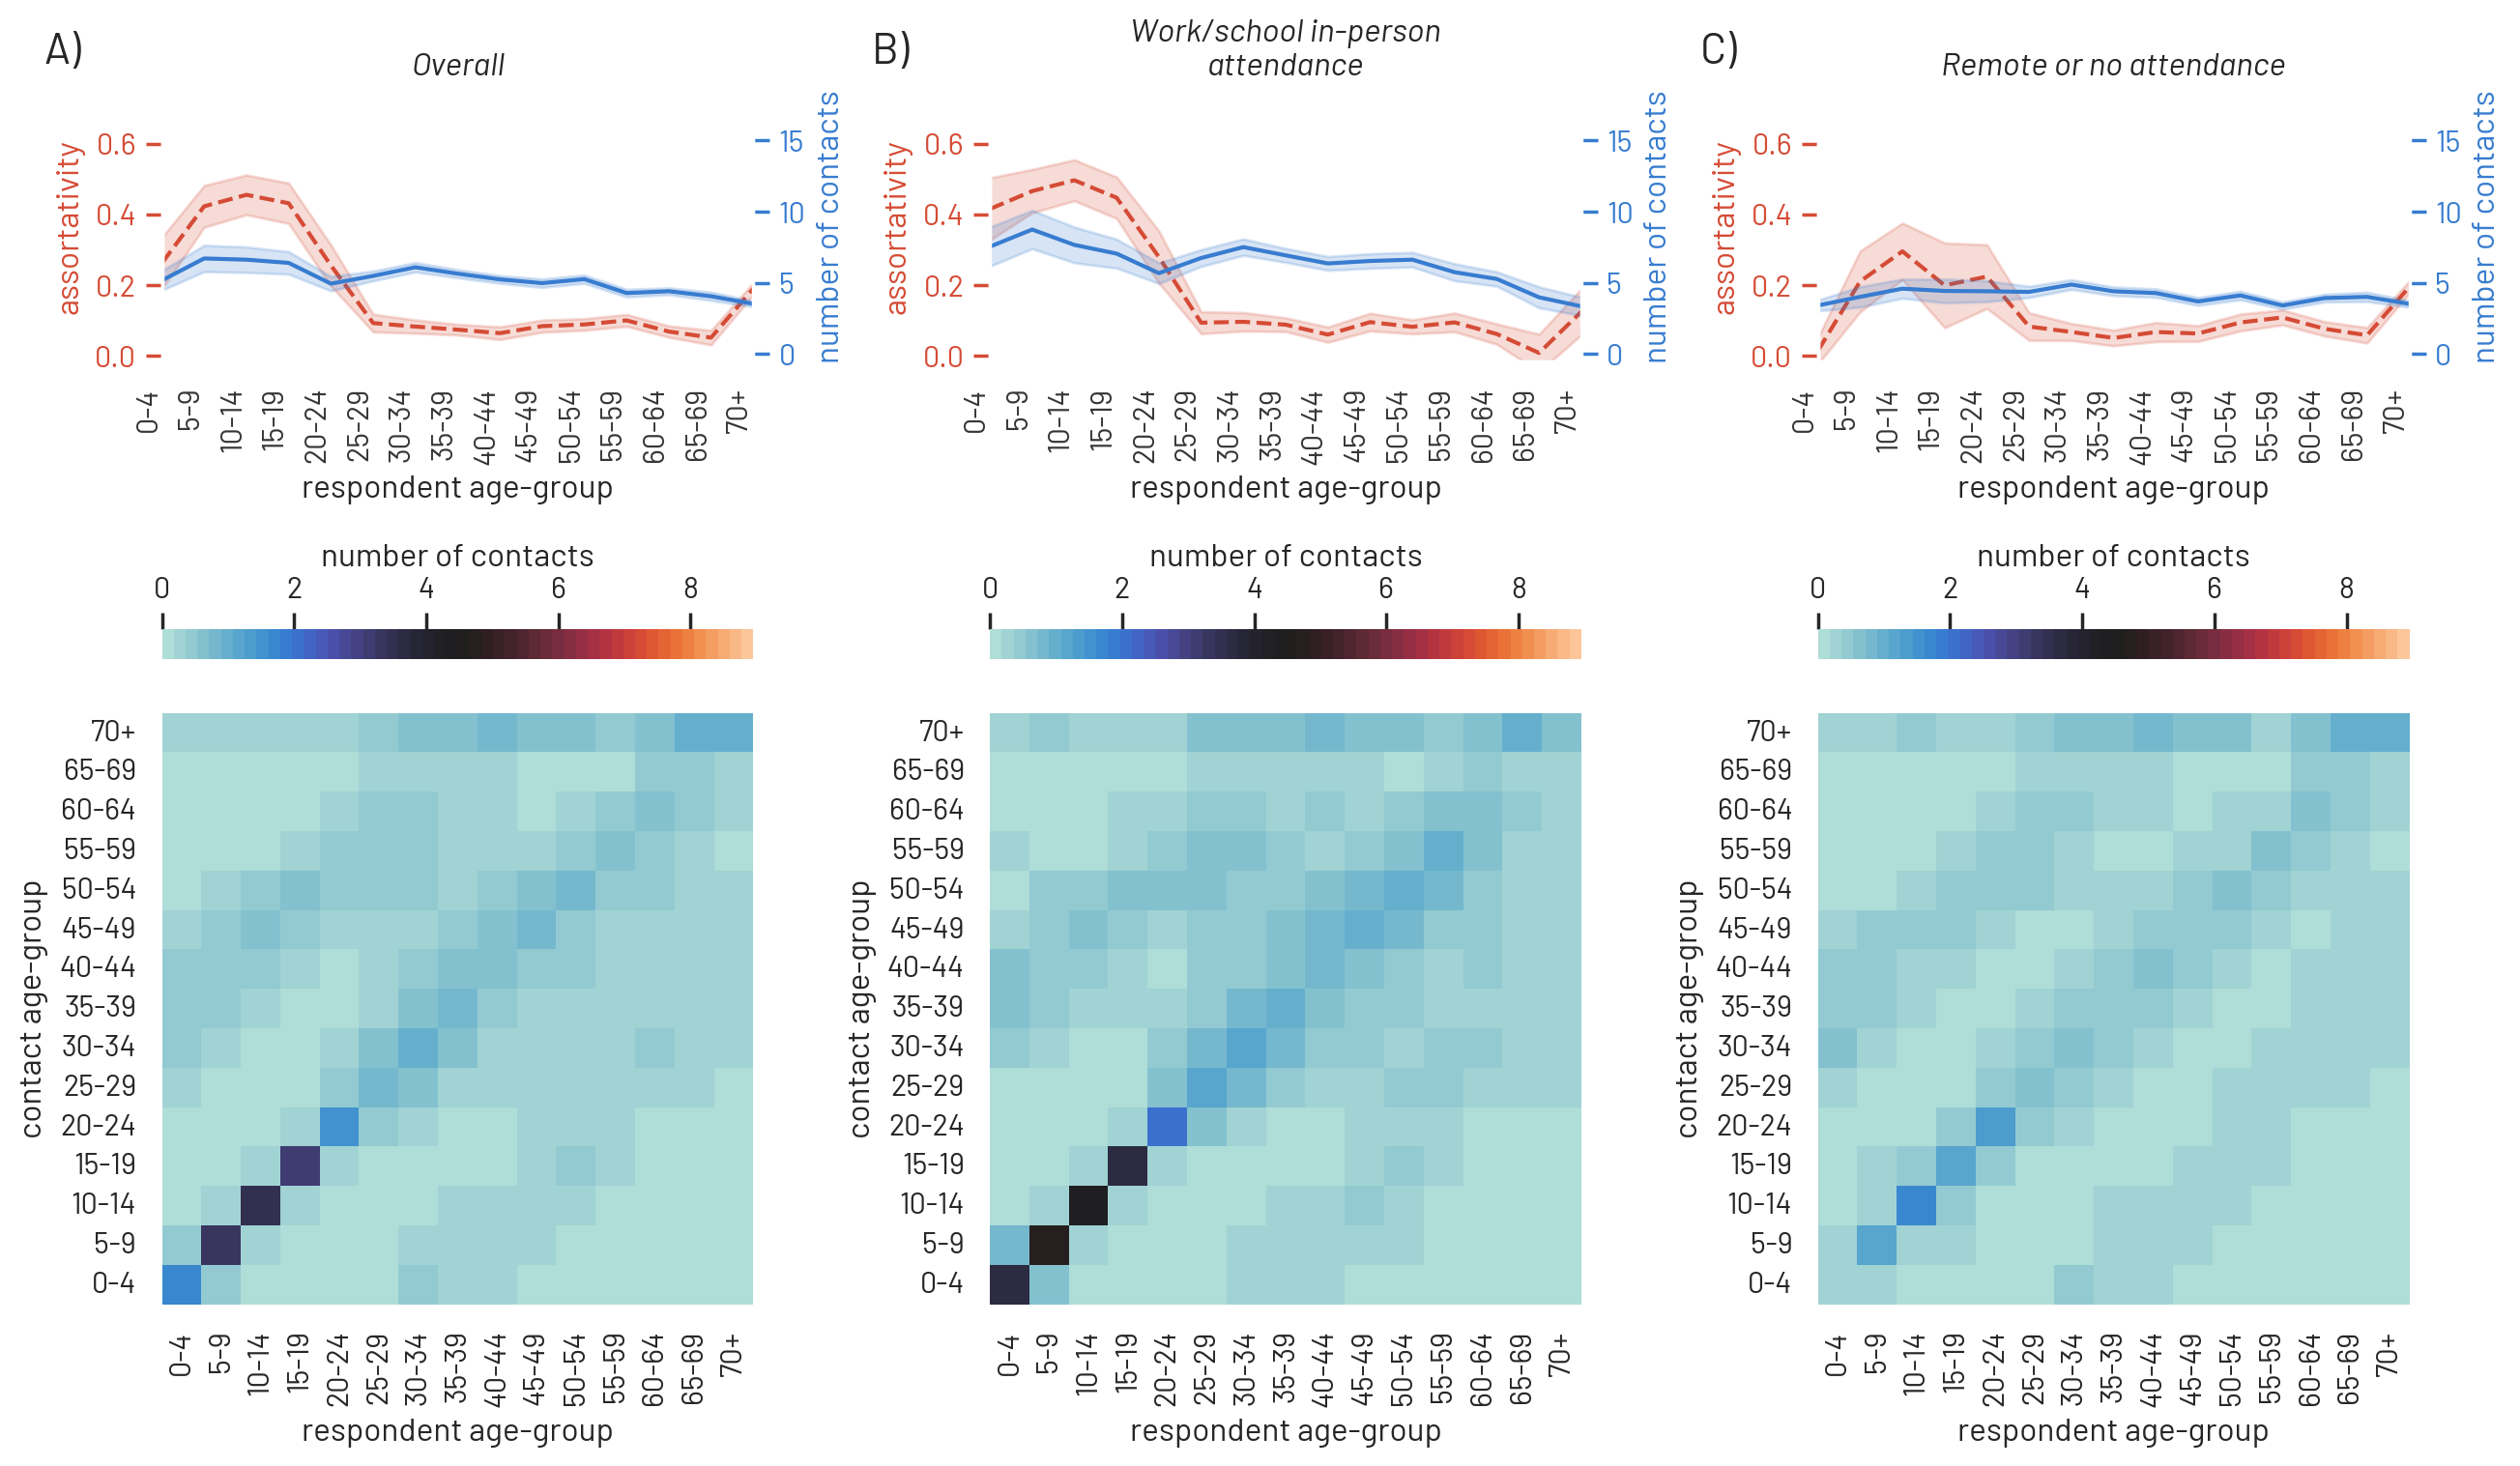

In [25]:
######### FIGURE drawing ##########
fsize=14
A_ylims = [(-.015,0.75),(-0.5,18.5)]
C_lims=(0,8.95)
fig1, ax = plt.subplot_mosaic([['A','B','C'],['D','E','F']], gridspec_kw={'height_ratios': [0.2,.8]}, figsize=(15,10))
set_plot_style(ax['A'], legend=False,xlims=[0,14])
set_plot_style(ax['B'], legend=False,xlims=[0,14])
set_plot_style(ax['C'], legend=False,xlims=[0,14])

tmpA, qgA, dsxA = input_2A_dir
tmpB, qgB, dsxB = input_2B_dir
tmpC, qgC, dsxC = input_2C_dir

[ax['A'],ax['D']] = plot_contact_matrix(tmpA, qgA, dsxA, fig_title='Overall', Q=False, A_ylims=A_ylims, C_lims=C_lims, annotations=False, square=True, axs=[ax['A'],ax['D']])
[ax['B'],ax['E']] = plot_contact_matrix(tmpB, qgB, dsxB, fig_title='Work/school in-person\nattendance', Q=False, A_ylims=A_ylims, C_lims=C_lims, annotations=False, square=True, axs=[ax['B'],ax['E']])
[ax['C'],ax['F']] = plot_contact_matrix(tmpC, qgC, dsxC, fig_title='Remote or no attendance', Q=False, A_ylims=A_ylims, C_lims=C_lims, annotations=False, square=True, axs=[ax['C'],ax['F']])

for panel_up, panel_down in [('A','D'),('B','E'),('C','F')]:
    ax[panel_up].text(x=-.2,y=1.1, s=panel_up+')', fontweight ='normal', fontsize=16, transform=ax[panel_up].transAxes)
    # ax[panel_down].text(x=-.2,y=1.25, s=panel_down+')', fontweight ='normal', fontsize=16, transform=ax[panel_down].transAxes)
    ax[panel_up].set_facecolor('white')
    ax[panel_up].grid(False)
    
plt.subplots_adjust(wspace=0.4,hspace=0.2)
fig1.savefig(f'figures_out/SIfigure10_cm_age_group{"_"+str(age_groups) if age_groups !=5 else ""}_direct_contacts_only.pdf', bbox_inches='tight')

#### Direct + Indirect with SOFT contacts

In [26]:
# DIRECT contacts only
contactToPlot = cs.copy() # The number of contacts an individual had is computed as the direct contacts only
contactToPlot = contactToPlot.merge(ri[['part_id']],on='part_id', how='right')
respondentToPlot = ri.copy()

############## Computing Matrices
q, m = bootstrap_contact_matrices(respondentToPlot, respondentToPlot, contactToPlot, group_col, group_pop, order_col, bootstrap=bootstrap_iterations, 
                                  bootstrap_dir=f'{savedir}bootstrap_age_group{"_"+str(age_groups) if age_groups !=5 else ""}_soft_total/', index_NA=index_pop)

### Data PREPARATION
### averaging Qs and average contacts for each bootstrap iteration
q1g = pd.concat([q[coli] for coli in q.columns])
dsx1 = pd.concat([pd.DataFrame(index=m[0].index,columns=m[0].columns, data=mi).sum() for mi in m])
### Averaging bootstrapped matrices
tmp1 = pd.DataFrame(index=m[0].index,columns=m[0].columns, data=np.array([mi.values for mi in m]).mean(0))


input_2A_soft = [tmp1.copy(), q1g.copy(), dsx1.copy()]

#######################################################################
#######################################################################

# Compute c. mat. from rinfo and contacts for subsample of population #
#######################################################################
#### Set "attendance" to "True" to get "in presence" work/school matrices, set to "False" to get "remote/not-in-person/no workers" matrices
# If "attendance is None" get total matrices
attendance = True
if attendance: suffix = 'In-person'
else:          suffix = 'Not-in-person'
#######################################################################
subset_group = None
subset_value = None
sens=12
round_notes = 1

#### Select target respondent and their contacts
if group_pop not in respondentToPlot.columns:
    respondentToPlot[group_pop] = respondentToPlot[group_col].map(contactToPlot[[group_col,group_pop]].drop_duplicates().set_index(group_col).to_dict()[group_pop])
######## Select subset of respondents ! ########
if not attendance is None: rsi = respondentToPlot[(respondentToPlot['attendance']==attendance)].copy()  
else:                      rsi = respondentToPlot.copy()
################################################
cts = contactToPlot[contactToPlot['part_id'].isin(rsi['part_id'])].copy()
gl = cts[[group_col,order_col,group_pop]].dropna().drop_duplicates().sort_values(order_col).loc[:,group_col].dropna().unique()
#######################################################################
q, m = bootstrap_contact_matrices(respondentToPlot,rsi, cts, group_col, group_pop, order_col, group_loc, bootstrap=bootstrap_iterations, 
                                  bootstrap_dir=f'{savedir}bootstrap_age_group{"_"+str(age_groups) if age_groups !=5 else ""}_soft_total_{attendance_suffix_name[attendance]}/', index_NA=index_pop)
### averaging Qs and average contacts for each bootstrap iteration
q1g = pd.concat([q[coli] for coli in q.columns]).loc[gl]
dsx1 = pd.concat([pd.DataFrame(index=m[0].index,columns=m[0].columns, data=mi).sum() for mi in m]).loc[gl]
### Averaging bootstrapped matrices
tmp1 = pd.DataFrame(index=m[0].index,columns=m[0].columns, data=np.array([mi.values for mi in m]).mean(0))

input_2B_soft = [tmp1.copy(), q1g.copy(), dsx1.copy()]

#######################################################################
# Compute c. mat. from rinfo and contacts for subsample of population #
#######################################################################
#### Set "attendance" to "True" to get "in presence" work/school matrices, set to "False" to get "remote/not-in-person/no workers" matrices
# If "attendance is None" get total matrices
attendance = False
if attendance: suffix = 'In-person'
else:          suffix = 'Not-in-person'
#######################################################################
subset_group = None
subset_value = None
sens=12
round_notes = 1

#### Select target respondent and their contacts
if group_pop not in respondentToPlot.columns:
    respondentToPlot[group_pop] = respondentToPlot[group_col].map(contactToPlot[[group_col,group_pop]].drop_duplicates().set_index(group_col).to_dict()[group_pop])
######## Select subset of respondents ! ########
if not attendance is None: rsi = respondentToPlot[(respondentToPlot['attendance']==attendance)].copy()  
else:                      rsi = respondentToPlot.copy()
################################################
cts = contactToPlot[contactToPlot['part_id'].isin(rsi['part_id'])].copy()
gl = cts[[group_col,order_col,group_pop]].dropna().drop_duplicates().sort_values(order_col).loc[:,group_col].dropna().unique()
#######################################################################
q, m = bootstrap_contact_matrices(respondentToPlot,rsi, cts, group_col, group_pop, order_col, group_loc, bootstrap=bootstrap_iterations, 
                                  bootstrap_dir=f'{savedir}bootstrap_age_group{"_"+str(age_groups) if age_groups !=5 else ""}_soft_total_{attendance_suffix_name[attendance]}/', index_NA=index_pop)
### averaging Qs and average contacts for each bootstrap iteration
q1g = pd.concat([q[coli] for coli in q.columns]).loc[gl]
dsx1 = pd.concat([pd.DataFrame(index=m[0].index,columns=m[0].columns, data=mi).sum() for mi in m]).loc[gl]
### Averaging bootstrapped matrices
tmp1 = pd.DataFrame(index=m[0].index,columns=m[0].columns, data=np.array([mi.values for mi in m]).mean(0))

input_2C_soft = [tmp1.copy(), q1g.copy(), dsx1.copy()]
# #######################################################################


Bootstrapping ... 1000 / 1000	

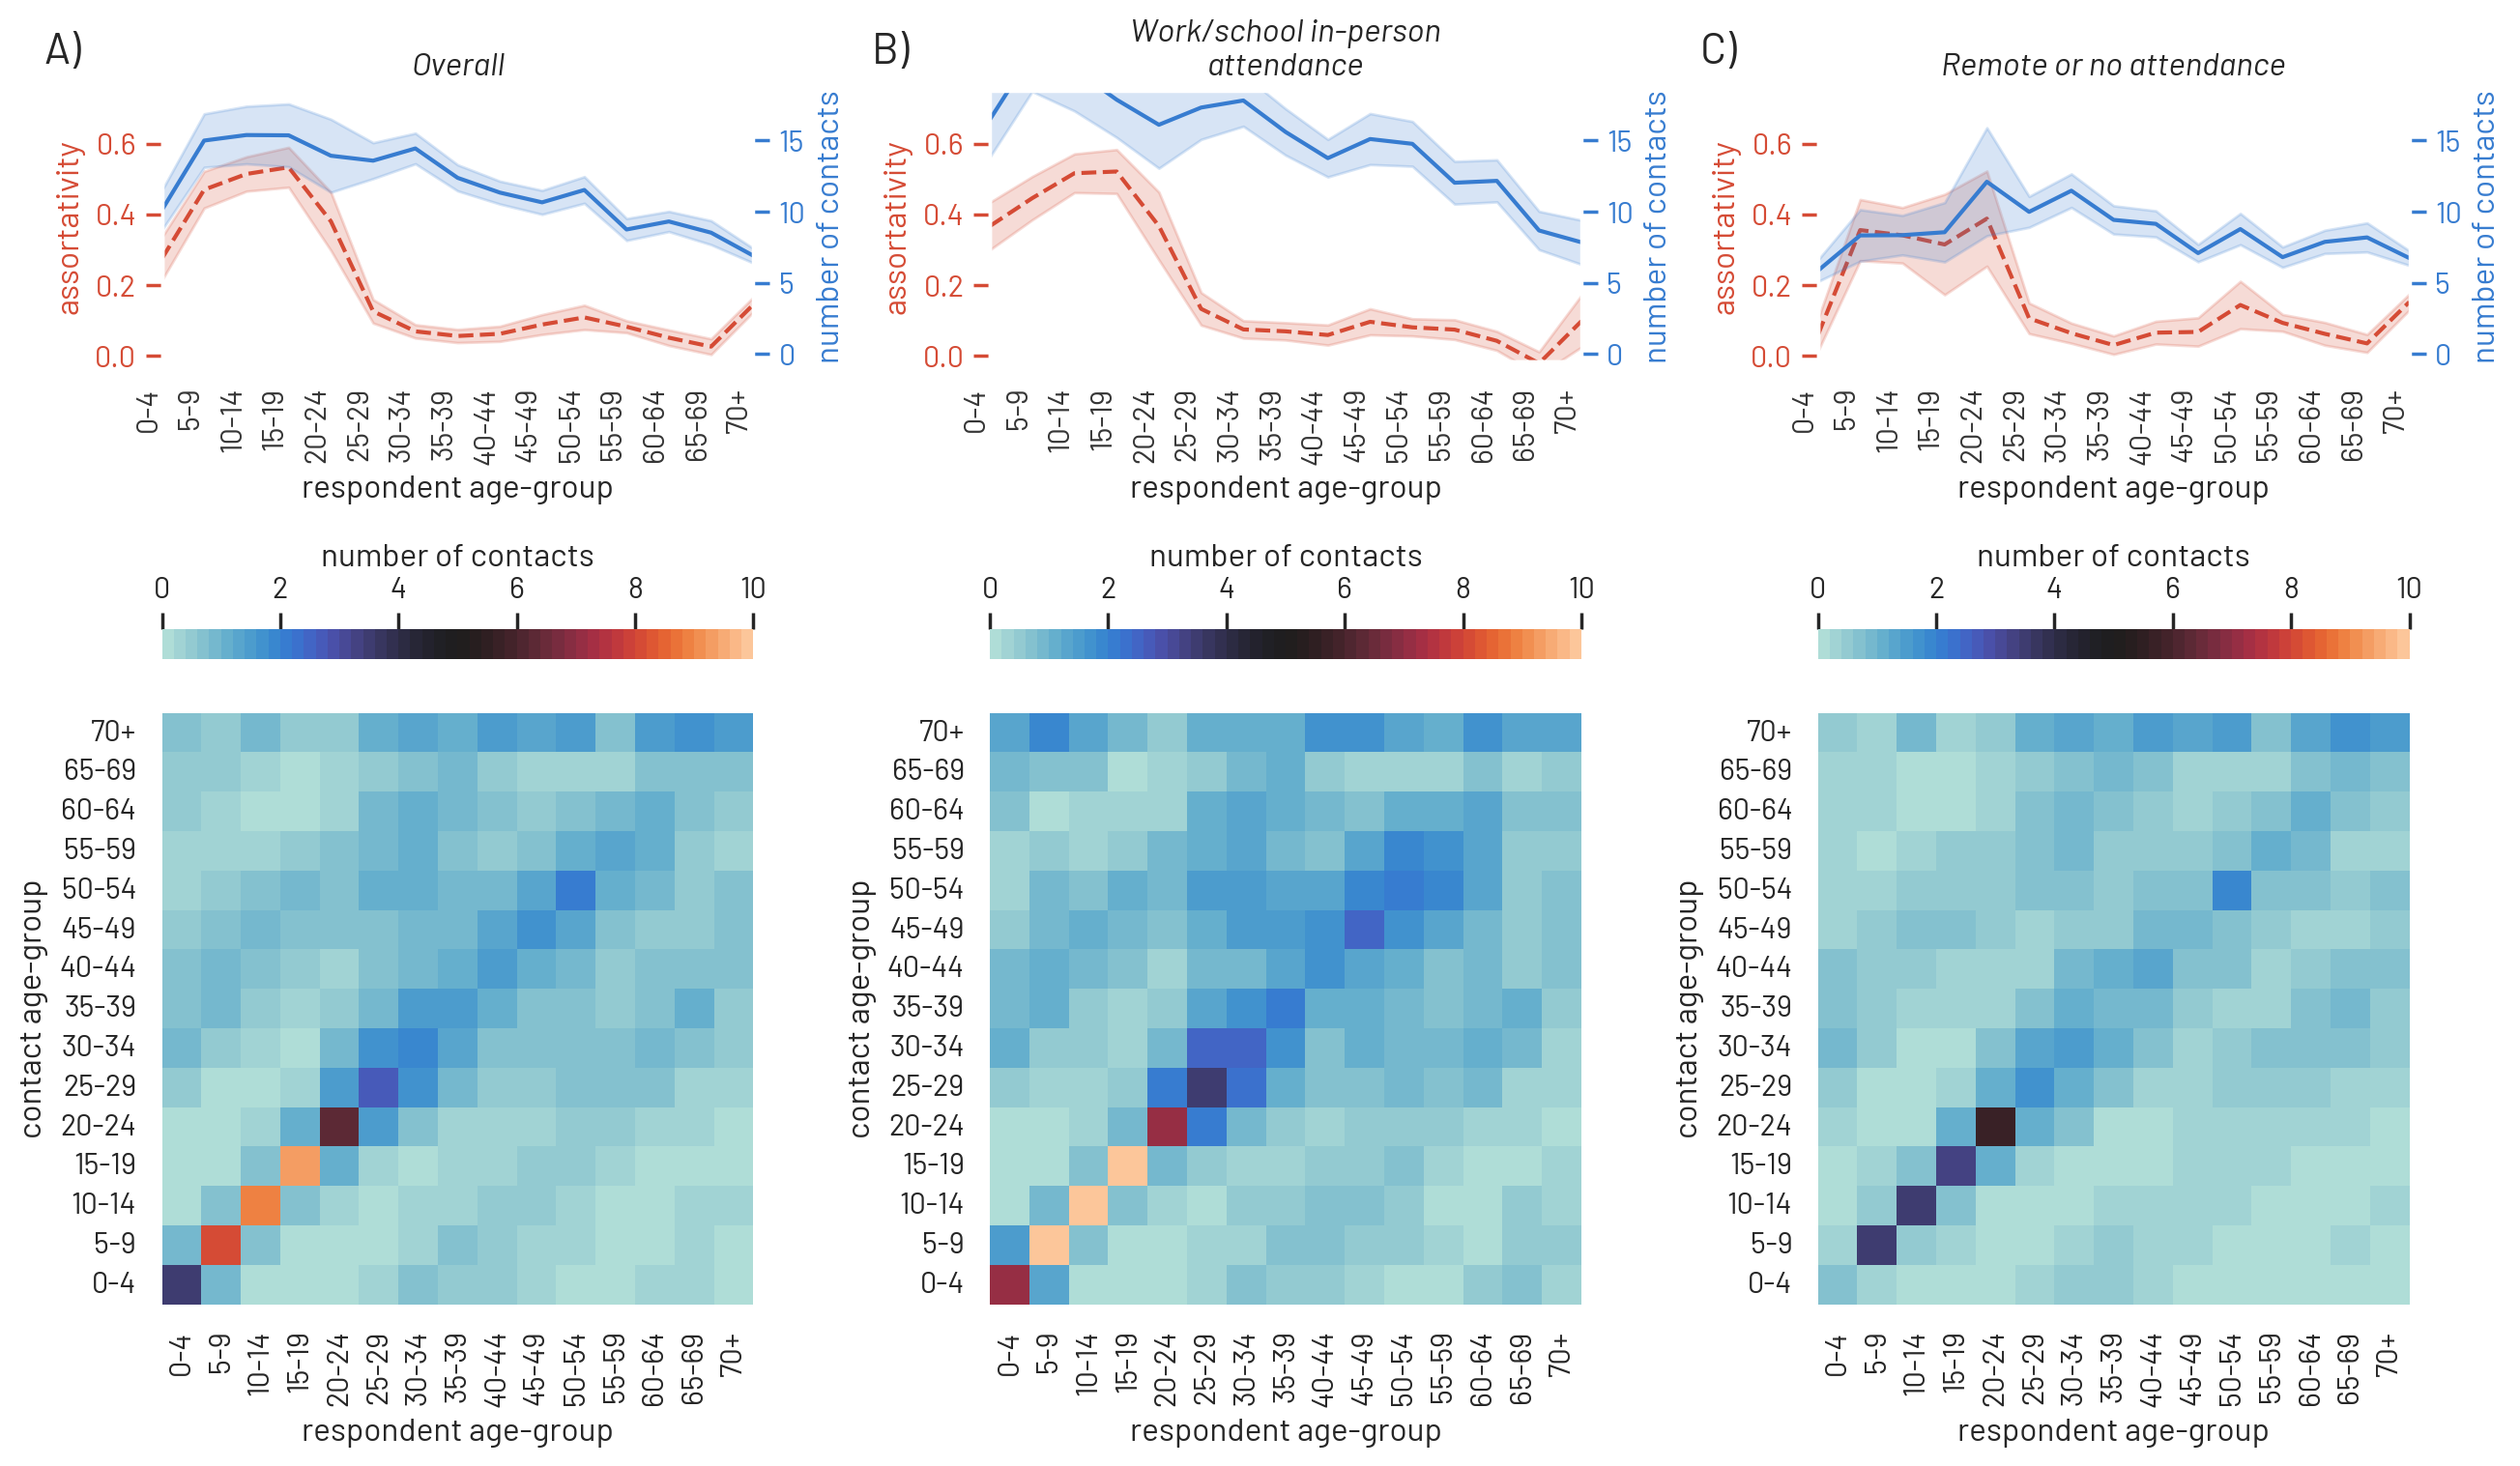

In [27]:
# #######################################################################
# #######################################################################
######### FIGURE drawing ##########
fsize=14

C_lims=(0,10)
fig1, ax = plt.subplot_mosaic([['A','B','C'],['D','E','F']], gridspec_kw={'height_ratios': [0.2,.8]}, figsize=(15,10))
set_plot_style(ax['A'], legend=False,xlims=[0,14])
set_plot_style(ax['B'], legend=False,xlims=[0,14])
set_plot_style(ax['C'], legend=False,xlims=[0,14])

tmpA, qgA, dsxA = input_2A_soft
tmpB, qgB, dsxB = input_2B_soft
tmpC, qgC, dsxC = input_2C_soft

[ax['A'],ax['D']] = plot_contact_matrix(tmpA, qgA, dsxA, fig_title='Overall', Q=False, A_ylims=A_ylims, C_lims=C_lims, annotations=False, square=True, axs=[ax['A'],ax['D']])
[ax['B'],ax['E']] = plot_contact_matrix(tmpB, qgB, dsxB, fig_title='Work/school in-person\nattendance', Q=False, A_ylims=A_ylims, C_lims=C_lims, annotations=False, square=True, axs=[ax['B'],ax['E']])
[ax['C'],ax['F']] = plot_contact_matrix(tmpC, qgC, dsxC, fig_title='Remote or no attendance', Q=False, A_ylims=A_ylims, C_lims=C_lims, annotations=False, square=True, axs=[ax['C'],ax['F']])

for panel_up, panel_down in [('A','D'),('B','E'),('C','F')]:
    ax[panel_up].text(x=-.2,y=1.1, s=panel_up+')', fontweight ='normal', fontsize=16, transform=ax[panel_up].transAxes)
    # ax[panel_down].text(x=-.2,y=1.25, s=panel_down+')', fontweight ='normal', fontsize=16, transform=ax[panel_down].transAxes)
    ax[panel_up].set_facecolor('white')
    ax[panel_up].grid(False)
    
plt.subplots_adjust(wspace=0.4,hspace=0.2)
fig1.savefig(f'figures_out/SIfigureNONE_cm_age_group{"_"+str(age_groups) if age_groups !=5 else ""}_direct_and_indirect_soft_contacts.pdf', bbox_inches='tight')

#### Direct + Indirect single setting augmentation

In [28]:
# Load respondents' and contacts' data
cs = pd.read_csv(f"data_out/contacts_prol_sing_sett_{age_groups}y_agegroups.csv")
ri = pd.read_csv(f"data_out/participants_rich_{age_groups}y_agegroups.csv")

ri[f'part_age_group_pop_{age_groups}'] = ri[f'part_age_group_{age_groups}'].map(population_vector.to_dict())
cs[f'part_age_group_pop_{age_groups}'] = cs[f'part_age_group_{age_groups}'].map(population_vector.to_dict())
cs[f'cnt_age_group_pop_{age_groups}'] = cs[f'cnt_age_group_{age_groups}'].map(population_vector.to_dict())

ri['attendance'] = ri['presence_work'].map({'In-person work': True, np.nan:False, 'No work':False, 'Remote work':False}) | ri['presence_school'].map({'In-person attendance': True, np.nan:False, 'No attendance':False, 'Remote attendance':False})

contactToPlot = cs[cs['is_soft']!=True].copy() # The numebr of contacts an individual had is computed as the non-overlapping sum of the direct contacts and the indirect contacts minus the indoor direct contacts
contactToPlot = contactToPlot.merge(ri[['part_id']],on='part_id', how='right')
respondentToPlot = ri.copy()

In [29]:
q, m = bootstrap_contact_matrices(respondentToPlot, respondentToPlot, contactToPlot, group_col, group_pop, order_col, 
                                  bootstrap=bootstrap_iterations, bootstrap_dir=f'{savedir}bootstrap_age_group{"_"+str(age_groups) if age_groups !=5 else ""}_singlesett_total/', index_NA=index_pop)

### Data PREPARATION
### averaging Qs and average contacts for each bootstrap iteration
q1g = pd.concat([q[coli] for coli in q.columns])
dsx1 = pd.concat([pd.DataFrame(index=m[0].index,columns=m[0].columns, data=mi).sum() for mi in m])
### Averaging bootstrapped matrices
tmp1 = pd.DataFrame(index=m[0].index,columns=m[0].columns, data=np.array([mi.values for mi in m]).mean(0))


input_2A_ss = [tmp1.copy(), q1g.copy(), dsx1.copy()]

#######################################################################
#######################################################################
#######################################################################
# Compute c. mat. from rinfo and contacts for subsample of population #
#######################################################################
#### Set "attendance" to "True" to get "in presence" work/school matrices, set to "False" to get "remote/not-in-person/no workers" matrices
# If "attendance is None" get total matrices
attendance = True
if attendance: suffix = 'In-person'
else:          suffix = 'Not-in-person'
#######################################################################
subset_group = None
subset_value = None
sens=12
round_notes = 1

#### Select target respondent and their contacts
if group_pop not in respondentToPlot.columns:
    respondentToPlot[group_pop] = respondentToPlot[group_col].map(contactToPlot[[group_col,group_pop]].drop_duplicates().set_index(group_col).to_dict()[group_pop])
######## Select subset of respondents ! ########
if not attendance is None: rsi = respondentToPlot[(respondentToPlot['attendance']==attendance)].copy()  
else:                      rsi = respondentToPlot.copy()
################################################
cts = contactToPlot[contactToPlot['part_id'].isin(rsi['part_id'])].copy()
gl = cts[[group_col,order_col,group_pop]].dropna().drop_duplicates().sort_values(order_col).loc[:,group_col].dropna().unique()
#######################################################################
q, m = bootstrap_contact_matrices(respondentToPlot,rsi, cts, group_col, group_pop, order_col, group_loc, bootstrap=bootstrap_iterations, 
                                  bootstrap_dir=f'{savedir}bootstrap_age_group{"_"+str(age_groups) if age_groups !=5 else ""}_singlesett_total_{attendance_suffix_name[attendance]}/', index_NA=index_pop)
### averaging Qs and average contacts for each bootstrap iteration
q1g = pd.concat([q[coli] for coli in q.columns]).loc[gl]
dsx1 = pd.concat([pd.DataFrame(index=m[0].index,columns=m[0].columns, data=mi).sum() for mi in m]).loc[gl]
### Averaging bootstrapped matrices
tmp1 = pd.DataFrame(index=m[0].index,columns=m[0].columns, data=np.array([mi.values for mi in m]).mean(0))

input_2B_ss = [tmp1.copy(), q1g.copy(), dsx1.copy()]

#######################################################################
# Compute c. mat. from rinfo and contacts for subsample of population #
#######################################################################
#### Set "attendance" to "True" to get "in presence" work/school matrices, set to "False" to get "remote/not-in-person/no workers" matrices
# If "attendance is None" get total matrices
attendance = False
if attendance: suffix = 'In-person'
else:          suffix = 'Not-in-person'
#######################################################################
subset_group = None
subset_value = None
sens=12
round_notes = 1

#### Select target respondent and their contacts
if group_pop not in respondentToPlot.columns:
    respondentToPlot[group_pop] = respondentToPlot[group_col].map(contactToPlot[[group_col,group_pop]].drop_duplicates().set_index(group_col).to_dict()[group_pop])
######## Select subset of respondents ! ########
if not attendance is None: rsi = respondentToPlot[(respondentToPlot['attendance']==attendance)].copy()  
else:                      rsi = respondentToPlot.copy()
################################################
cts = contactToPlot[contactToPlot['part_id'].isin(rsi['part_id'])].copy()
gl = cts[[group_col,order_col,group_pop]].dropna().drop_duplicates().sort_values(order_col).loc[:,group_col].dropna().unique()
#######################################################################
q, m = bootstrap_contact_matrices(respondentToPlot,rsi, cts, group_col, group_pop, order_col, group_loc, bootstrap=bootstrap_iterations, 
                                  bootstrap_dir=f'{savedir}bootstrap_age_group{"_"+str(age_groups) if age_groups !=5 else ""}_singlestt_total_{attendance_suffix_name[attendance]}/', index_NA=index_pop)
### averaging Qs and average contacts for each bootstrap iteration
q1g = pd.concat([q[coli] for coli in q.columns]).loc[gl]
dsx1 = pd.concat([pd.DataFrame(index=m[0].index,columns=m[0].columns, data=mi).sum() for mi in m]).loc[gl]
### Averaging bootstrapped matrices
tmp1 = pd.DataFrame(index=m[0].index,columns=m[0].columns, data=np.array([mi.values for mi in m]).mean(0))

input_2C_ss = [tmp1.copy(), q1g.copy(), dsx1.copy()]
# #######################################################################


Bootstrapping ... 1000 / 1000	

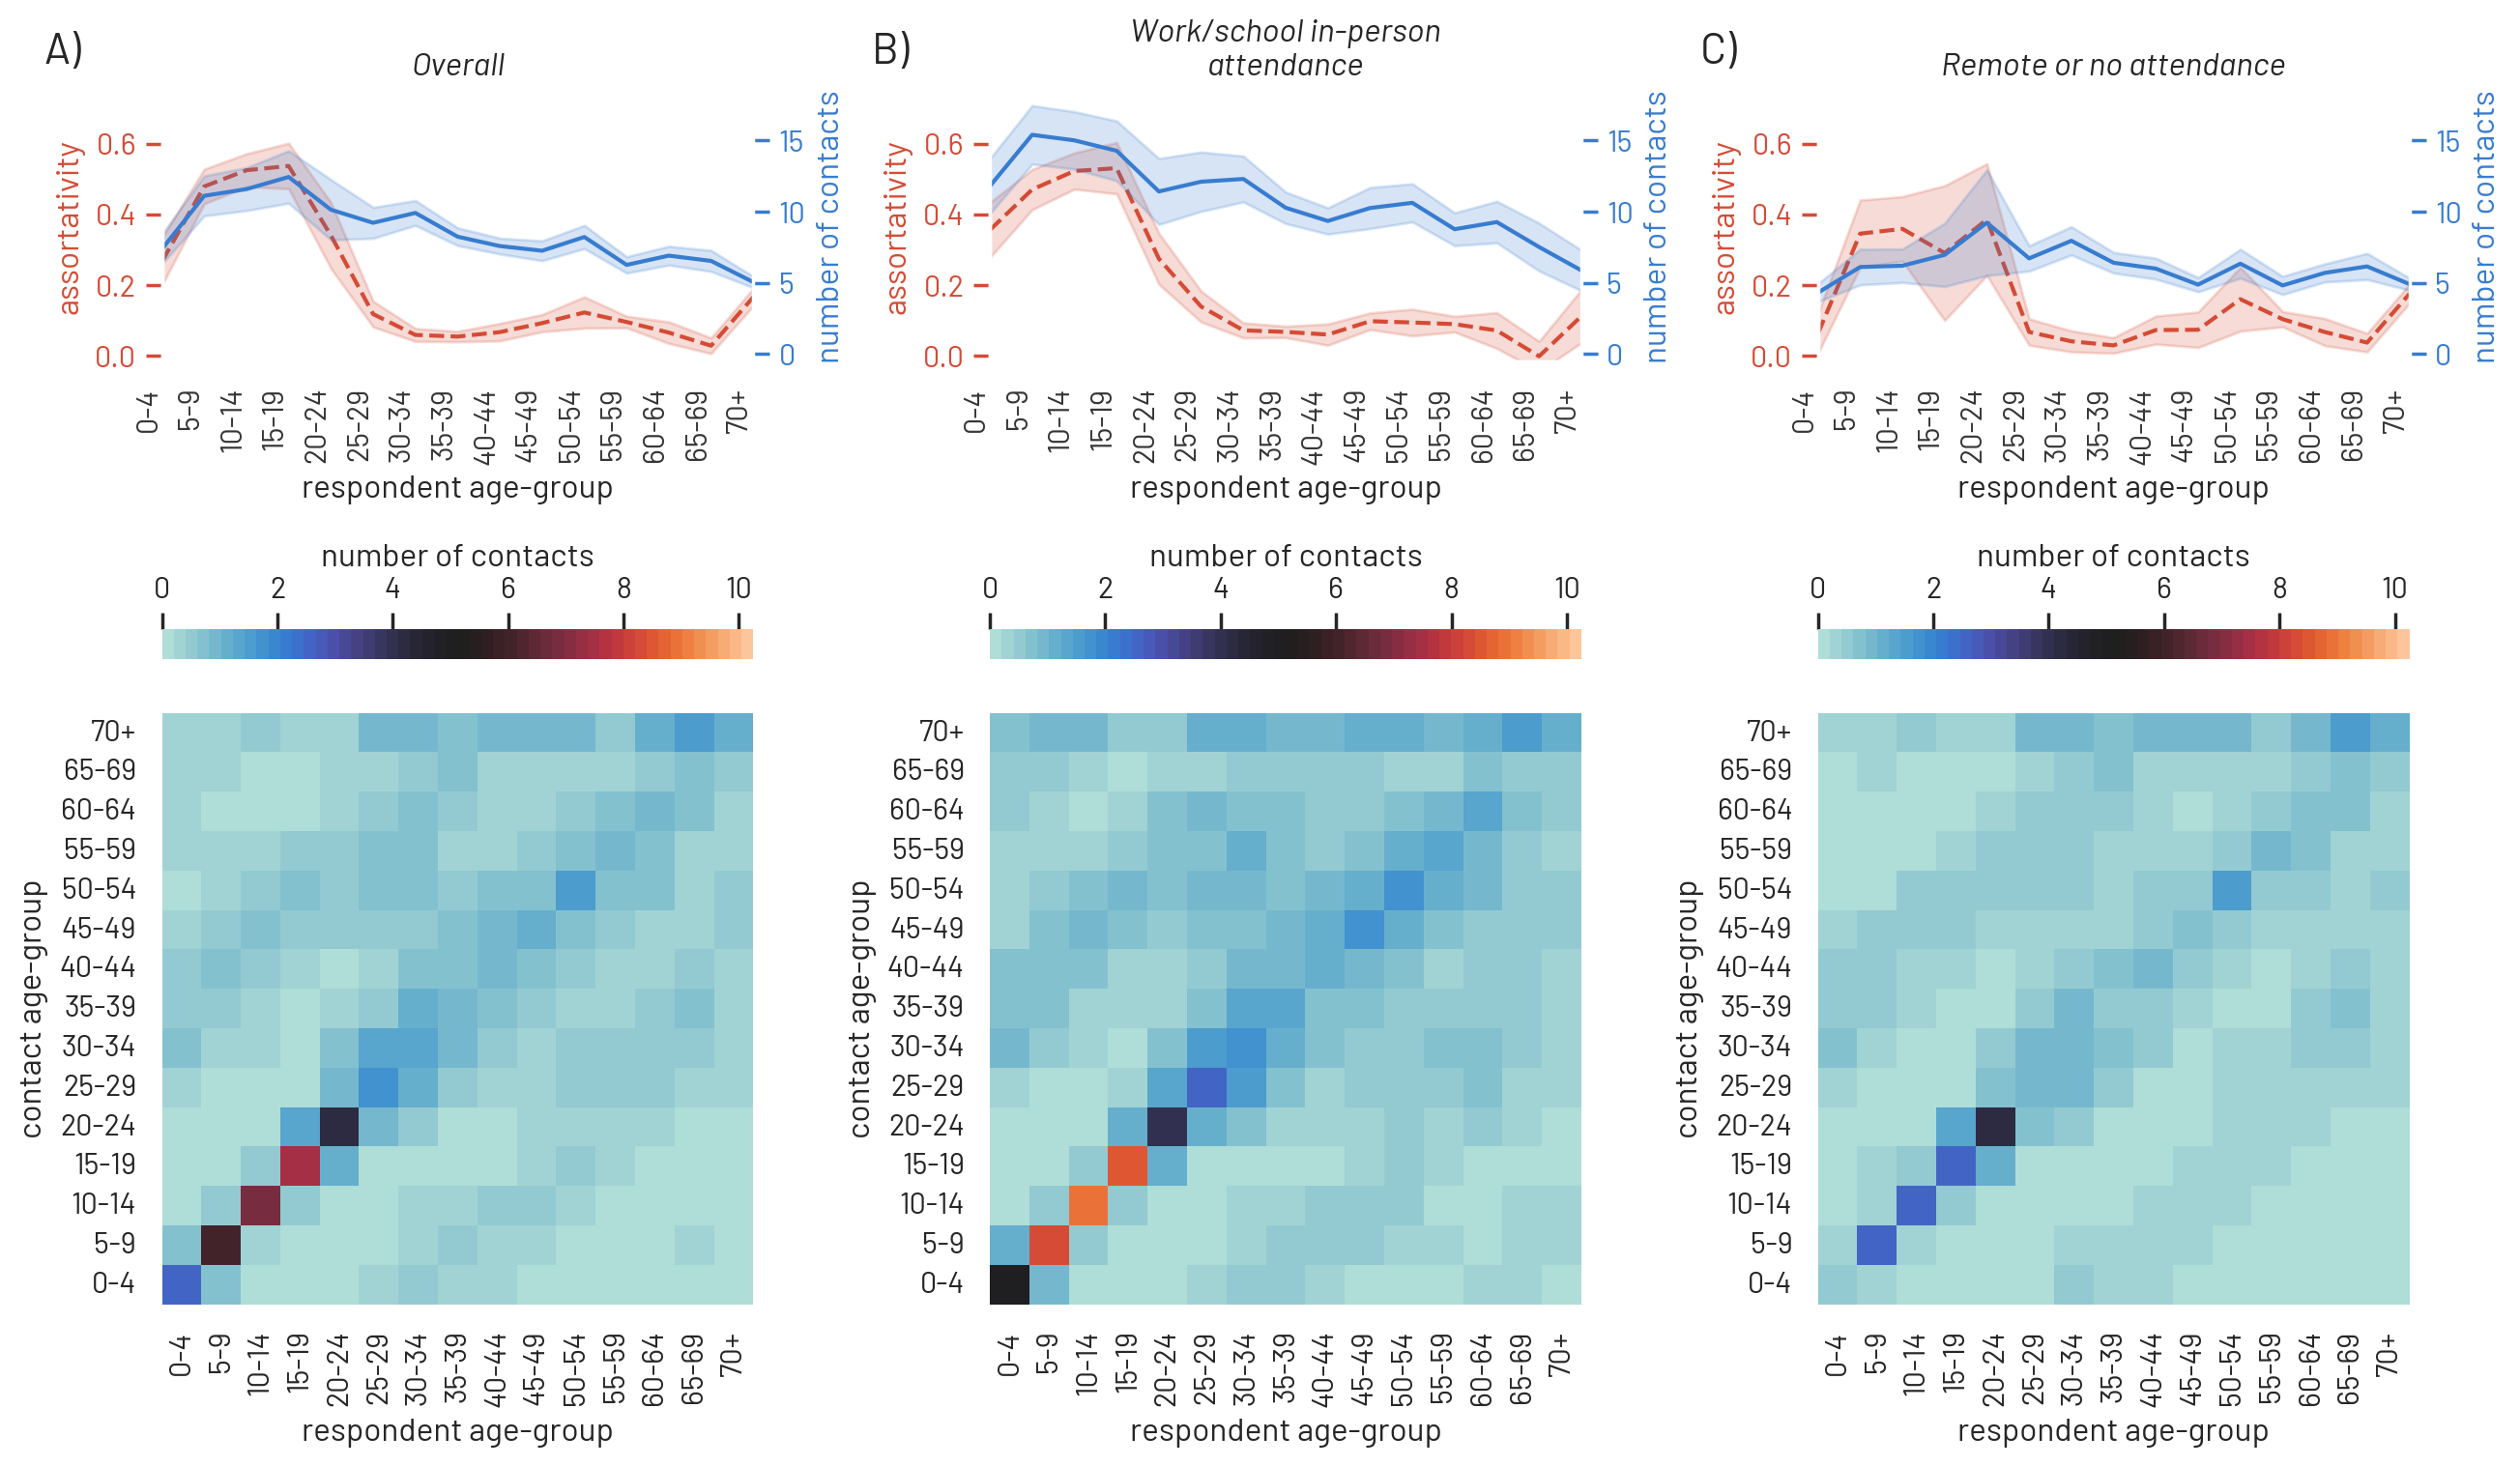

In [30]:
######### FIGURE drawing ##########
fsize=14
C_lims=(0,10.25)
fig1, ax = plt.subplot_mosaic([['A','B','C'],['D','E','F']], gridspec_kw={'height_ratios': [0.2,.8]}, figsize=(15,10))
set_plot_style(ax['A'], legend=False,xlims=[0,14])
set_plot_style(ax['B'], legend=False,xlims=[0,14])
set_plot_style(ax['C'], legend=False,xlims=[0,14])

tmpA, qgA, dsxA = input_2A_ss
tmpB, qgB, dsxB = input_2B_ss
tmpC, qgC, dsxC = input_2C_ss

[ax['A'],ax['D']] = plot_contact_matrix(tmpA, qgA, dsxA, fig_title='Overall', Q=False, A_ylims=A_ylims, C_lims=C_lims, annotations=False, square=True, axs=[ax['A'],ax['D']])
[ax['B'],ax['E']] = plot_contact_matrix(tmpB, qgB, dsxB, fig_title='Work/school in-person\nattendance', Q=False, A_ylims=A_ylims, C_lims=C_lims, annotations=False, square=True, axs=[ax['B'],ax['E']])
[ax['C'],ax['F']] = plot_contact_matrix(tmpC, qgC, dsxC, fig_title='Remote or no attendance', Q=False, A_ylims=A_ylims, C_lims=C_lims, annotations=False, square=True, axs=[ax['C'],ax['F']])

for panel_up, panel_down in [('A','D'),('B','E'),('C','F')]:
    ax[panel_up].text(x=-.2,y=1.1, s=panel_up+')', fontweight ='normal', fontsize=16, transform=ax[panel_up].transAxes)
    # ax[panel_down].text(x=-.2,y=1.25, s=panel_down+')', fontweight ='normal', fontsize=16, transform=ax[panel_down].transAxes)
    ax[panel_up].set_facecolor('white')
    ax[panel_up].grid(False)
    
plt.subplots_adjust(wspace=0.4,hspace=0.2)
fig1.savefig(f'figures_out/SIfigure12_cm_age_group{"_"+str(age_groups) if age_groups !=5 else ""}_direct_and_indirects_single_setting.pdf', bbox_inches='tight')

### SI Matrices by setting

#### Total Contacts by setting

In [31]:
###########################
savedir = 'data_out/matrices/bootstrap/'
A_ylims = [(-.01,0.75),(-0.5,18.5)]
si_matrices = None # "sing_sett" / "direct" / "soft" / None # to switch from different sensitivity scenarios: direct (only), dominant_setting augmentation (single setting), or proportional setting augmentation (main analysis))

# Select which age groups to use (NOTE: specific contacts and respondent data will be loaded, see cell below.)
bootstrap_iterations = 1000
age_groups = 10

###########################
# Loading Italian population data as of January 2022
ag = pd.read_csv('data_in/age_gender.csv')
ag['age'] = ag['Età'].apply(lambda x: x.split(' ')[0])
ag = ag[(ag['Sesso']=='totale')&(ag['age']!='totale')&(ag['Territorio']=='Italia')]
ag = ag.groupby('age')['Value'].sum().reset_index()
ag = ag.astype({'age':int, 'Value':int}).sort_values('age').reset_index(drop=True)
ag[f'pop_{age_groups}'] = pd.cut(ag['age'], 
                                 bins=[i for i in range(0,75,age_groups)]+[150], 
                                 labels=[f'{i}-{i+age_groups-1}' for i in range(0,70,age_groups)]+['70+'], 
                                 right=True, include_lowest=True)
population_vector = ag.groupby(f'pop_{age_groups}', observed=False)['Value'].sum()

###########################
order_col = 'part_age'
group_col = f'part_age_group_{age_groups}'     # selected age_group of interest
group_pop = f'part_age_group_pop_{age_groups}' # population vector mapped to each respondent age_group

# Load respondents' and contacts' data
if (si_matrices == 'sing_sett') | (si_matrices == 'prolonged_dominant'): # "prolonged_dominant" is legacy name
    cs = pd.read_csv(f"data_out/contacts_prol_sing_sett_{age_groups}y_agegroups.csv")
else:
    cs = pd.read_csv(f"data_out/contacts_prol_prop_{age_groups}y_agegroups.csv")
ri = pd.read_csv(f"data_out/participants_rich_{age_groups}y_agegroups.csv")

ri[f'part_age_group_pop_{age_groups}'] = ri[f'part_age_group_{age_groups}'].map(population_vector.to_dict())
cs[f'part_age_group_pop_{age_groups}'] = cs[f'part_age_group_{age_groups}'].map(population_vector.to_dict())
cs[f'cnt_age_group_pop_{age_groups}'] = cs[f'cnt_age_group_{age_groups}'].map(population_vector.to_dict())

ri['attendance'] = ri['presence_work'].map({'In-person work': True, np.nan:False, 'No work':False, 'Remote work':False}) | ri['presence_school'].map({'In-person attendance': True, np.nan:False, 'No attendance':False, 'Remote attendance':False})


########################################################################
### Selecting contacts and respondents of interest 
########################################################################
if (si_matrices=='direct') | (si_matrices == 'direct_only'):
    contactToPlot = cs[cs['is_soft'].isna()].copy() # The number of contacts an individual had is computed as the direct contacts only
elif (si_matrices =='soft'):
    contactToPlot = cs[cs['is_soft']!=True].copy() # In case of "soft" all contacts are used
else:
    contactToPlot = cs[cs['is_soft']!=True].copy() # The number of contacts an individual had is computed as the non-overlapping sum of the direct contacts and the indirect contacts minus the indoor direct contacts
contactToPlot = contactToPlot.merge(ri[['part_id']],on='part_id', how='right')
respondentToPlot = ri.copy()

index_pop = respondentToPlot.drop_duplicates(group_col).sort_values(order_col).set_index(group_col)[group_pop].to_dict()
group_loc = contactToPlot[[group_col,order_col,group_pop]].dropna().drop_duplicates().sort_values(order_col).loc[:,group_col].dropna().unique()


Home
Bootstrapping ... 1000 / 1000	
Work
Bootstrapping ... 1000 / 1000	
School
Bootstrapping ... 1000 / 1000	
Leisure
Bootstrapping ... 1000 / 1000	
Transport
Bootstrapping ... 1000 / 1000	
Other
Bootstrapping ... 1000 / 1000	

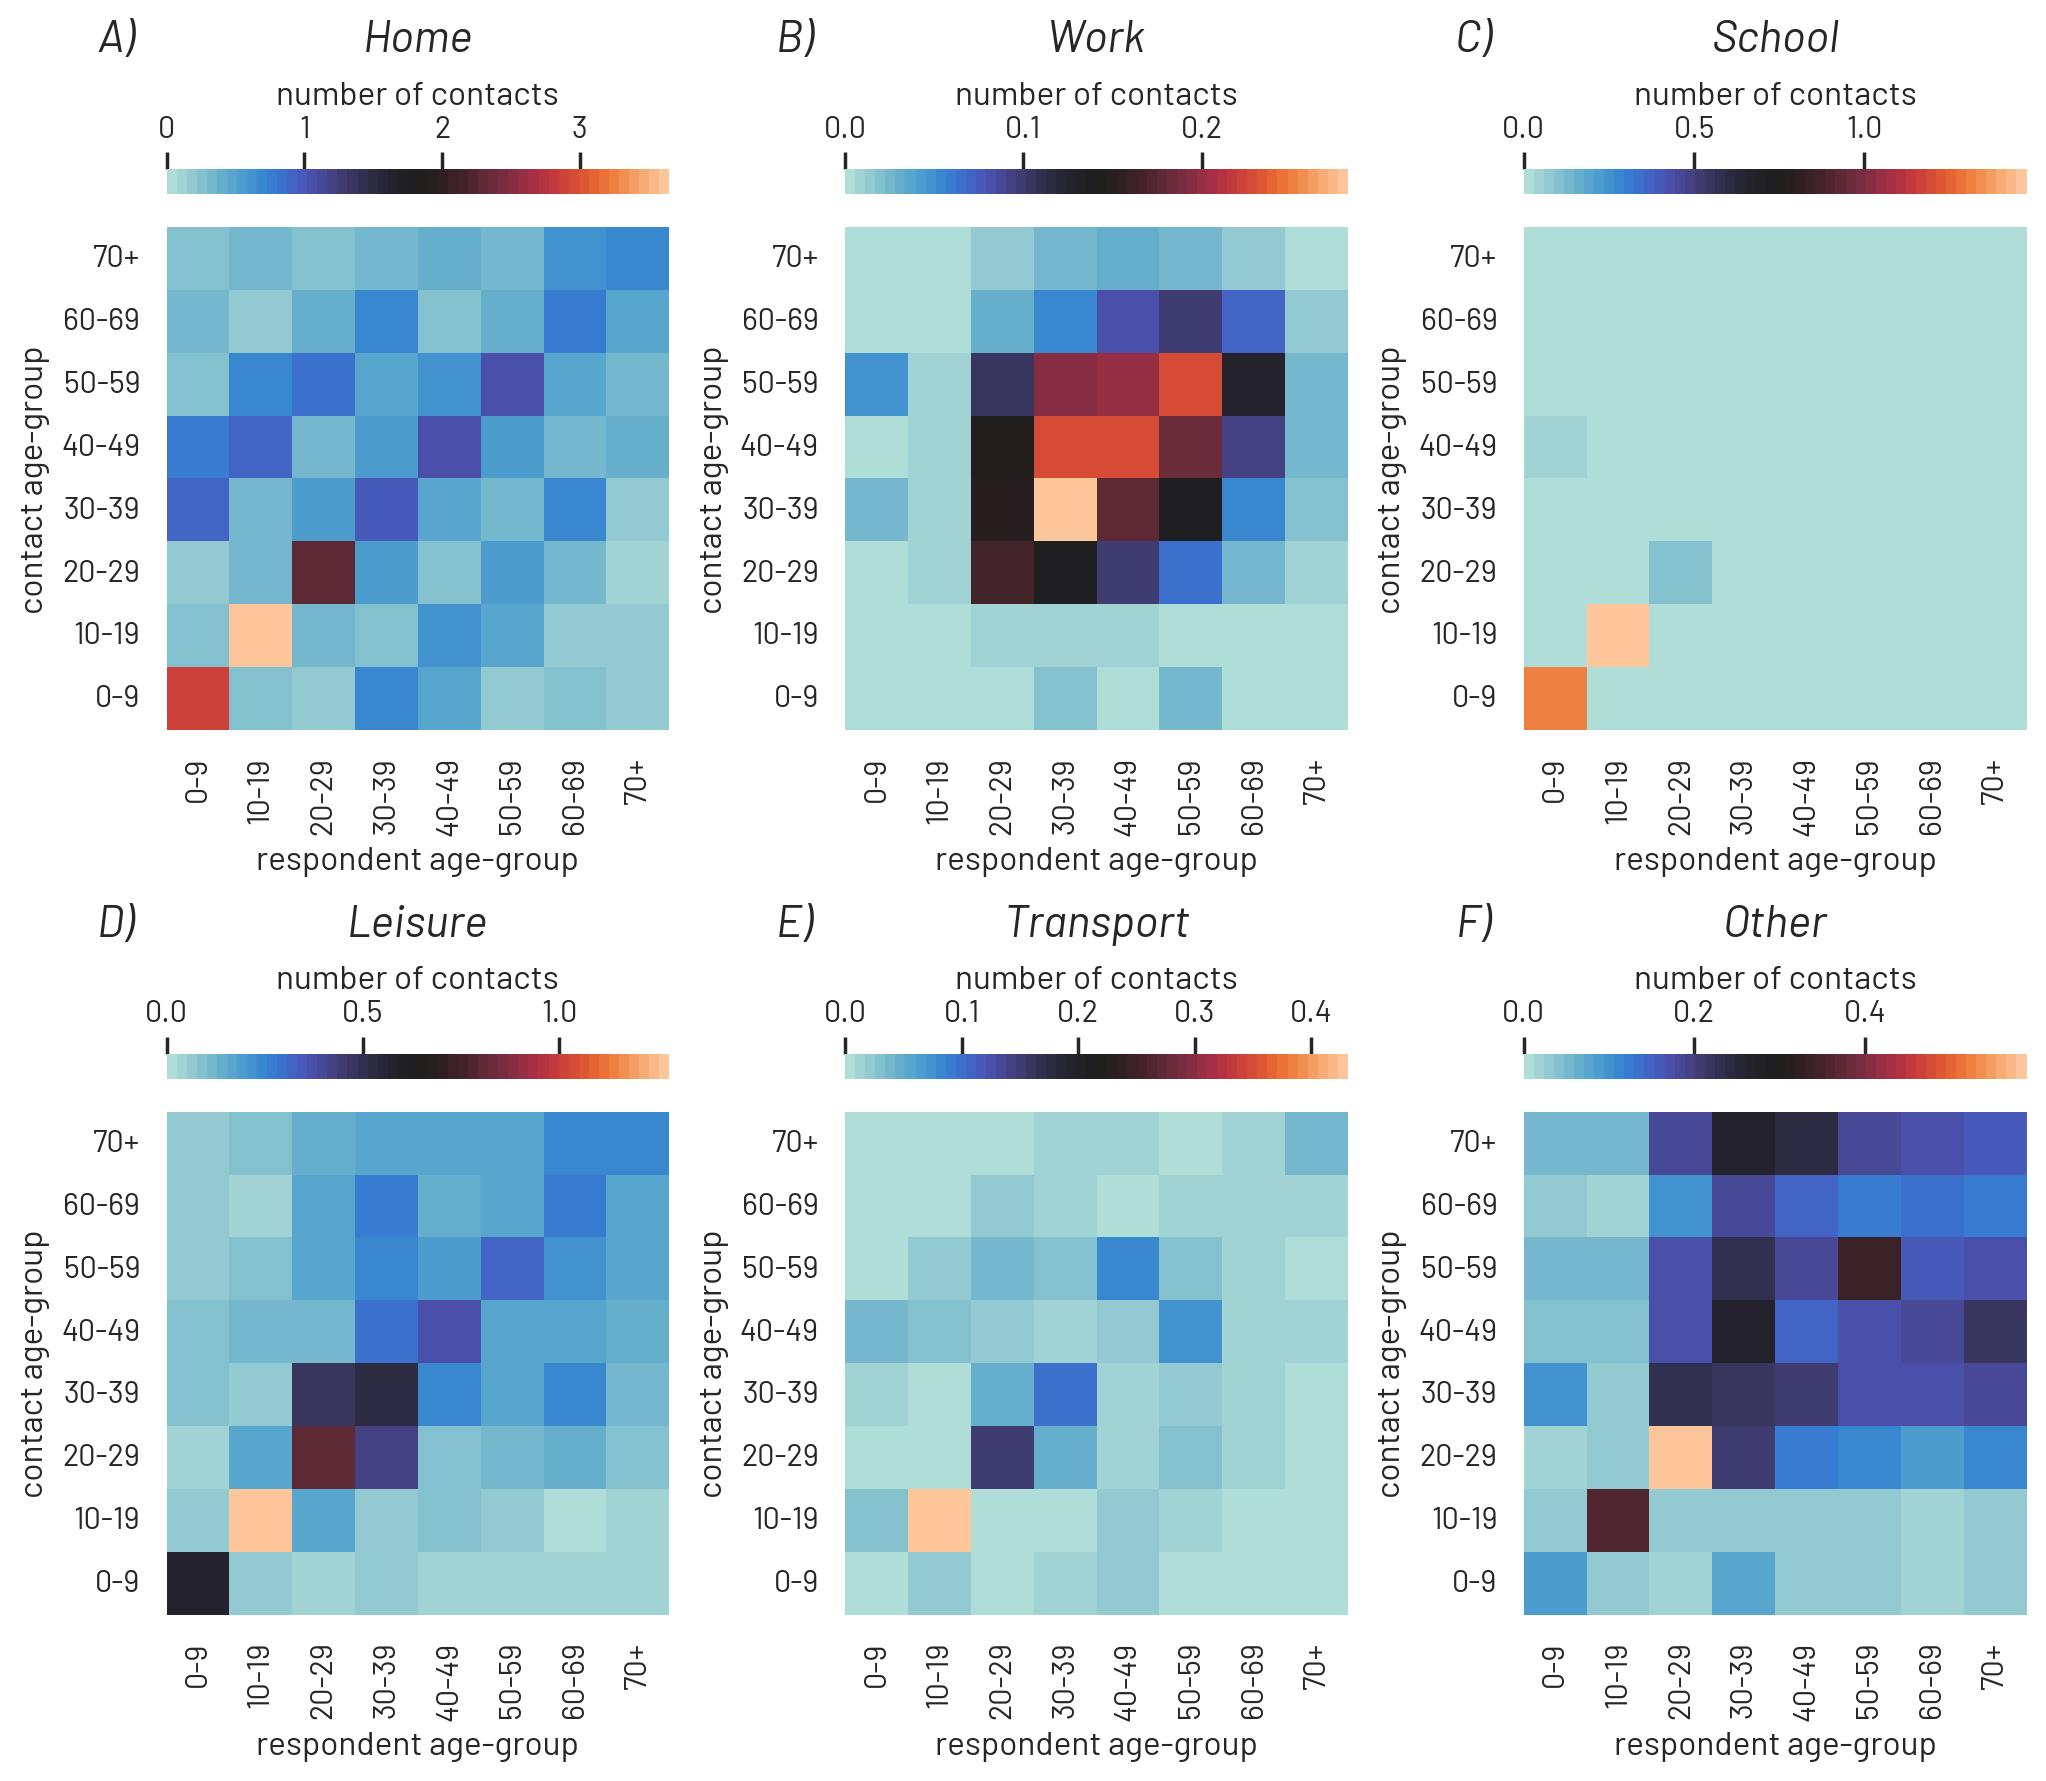

In [32]:
######### FIGURE drawing ##########
c_lims = {}
fig1, axs = plt.subplot_mosaic([['Home','Work','School'],['Leisure','Transport','Other']],figsize=(12,10))
plt.subplots_adjust(wspace=.35,hspace=0.4)
for ii,loc in enumerate(['Home','Work','School','Leisure','Transport','Other']):
    print(f'\n{loc}')
    rsi = respondentToPlot.copy() # whatever respondent...entire data or any subset
    cts = contactToPlot[contactToPlot['part_id'].isin(rsi['part_id'].tolist())]
    cts['cont_id'] = cts[['location_multi','cont_id']].apply(lambda x: nan_col(x,loc,'location_multi'), axis=1)
    # compute reciprocal and return avg.contacts per group_col and bootstrap
    q, m = bootstrap_contact_matrices(respondentToPlot, rsi, cts, group_col, group_pop, order_col, bootstrap=bootstrap_iterations, 
                                      bootstrap_dir=f'{savedir}bootstrap_age_group{"_"+str(age_groups) if age_groups !=5 else ""}_{loc.lower()}/', index_NA=index_pop)
    ### averaging Qs and average contacts for each bootstrap iteration
    q1g = pd.concat([q[coli] for coli in q.columns])
    dsx0 = pd.concat([pd.DataFrame(index=m[0].index,columns=m[0].columns, data=mi).sum() for mi in m])
    ### Averaging bootstrapped matrices
    tmp0 = pd.DataFrame(index=m[0].index,columns=m[0].columns, data=np.nanmean(np.array([mi.values for mi in m]),0))
    c_lims[loc] = (0,tmp0.max().max())
    ###################################
    ######### FIGURE drawing ##########
    ###################################
    axs[loc] = plot_contact_matrix(tmp0, q1g, dsx0, loc, Q=False, 
                                   A_ylims=A_ylims, 
                                   annotations=False, square=True, matrix_only=True, 
                                   axs=[axs[loc]])
    axs[loc].text(x=-.1,y=1.35, s=['A)','B)','C)','D)','E)','F)'][ii], fontweight ='normal', fontstyle='italic', fontsize=16, transform=axs[loc].transAxes, horizontalalignment='center')
    axs[loc].text(x=.5,y=1.35, s=loc, fontweight ='normal', fontstyle='italic', fontsize=16, transform=axs[loc].transAxes, horizontalalignment='center')
fig1.savefig(f'figures_out/SIfigure6_cmat_age_group{"_"+str(age_groups) if age_groups !=5 else ""}_by_setting.pdf', bbox_inches='tight')



Home
Bootstrapping ... 1000 / 1000	
Work
Bootstrapping ... 1000 / 1000	
School
Bootstrapping ... 1000 / 1000	
Leisure
Bootstrapping ... 1000 / 1000	
Transport
Bootstrapping ... 1000 / 1000	
Other
Bootstrapping ... 1000 / 1000	

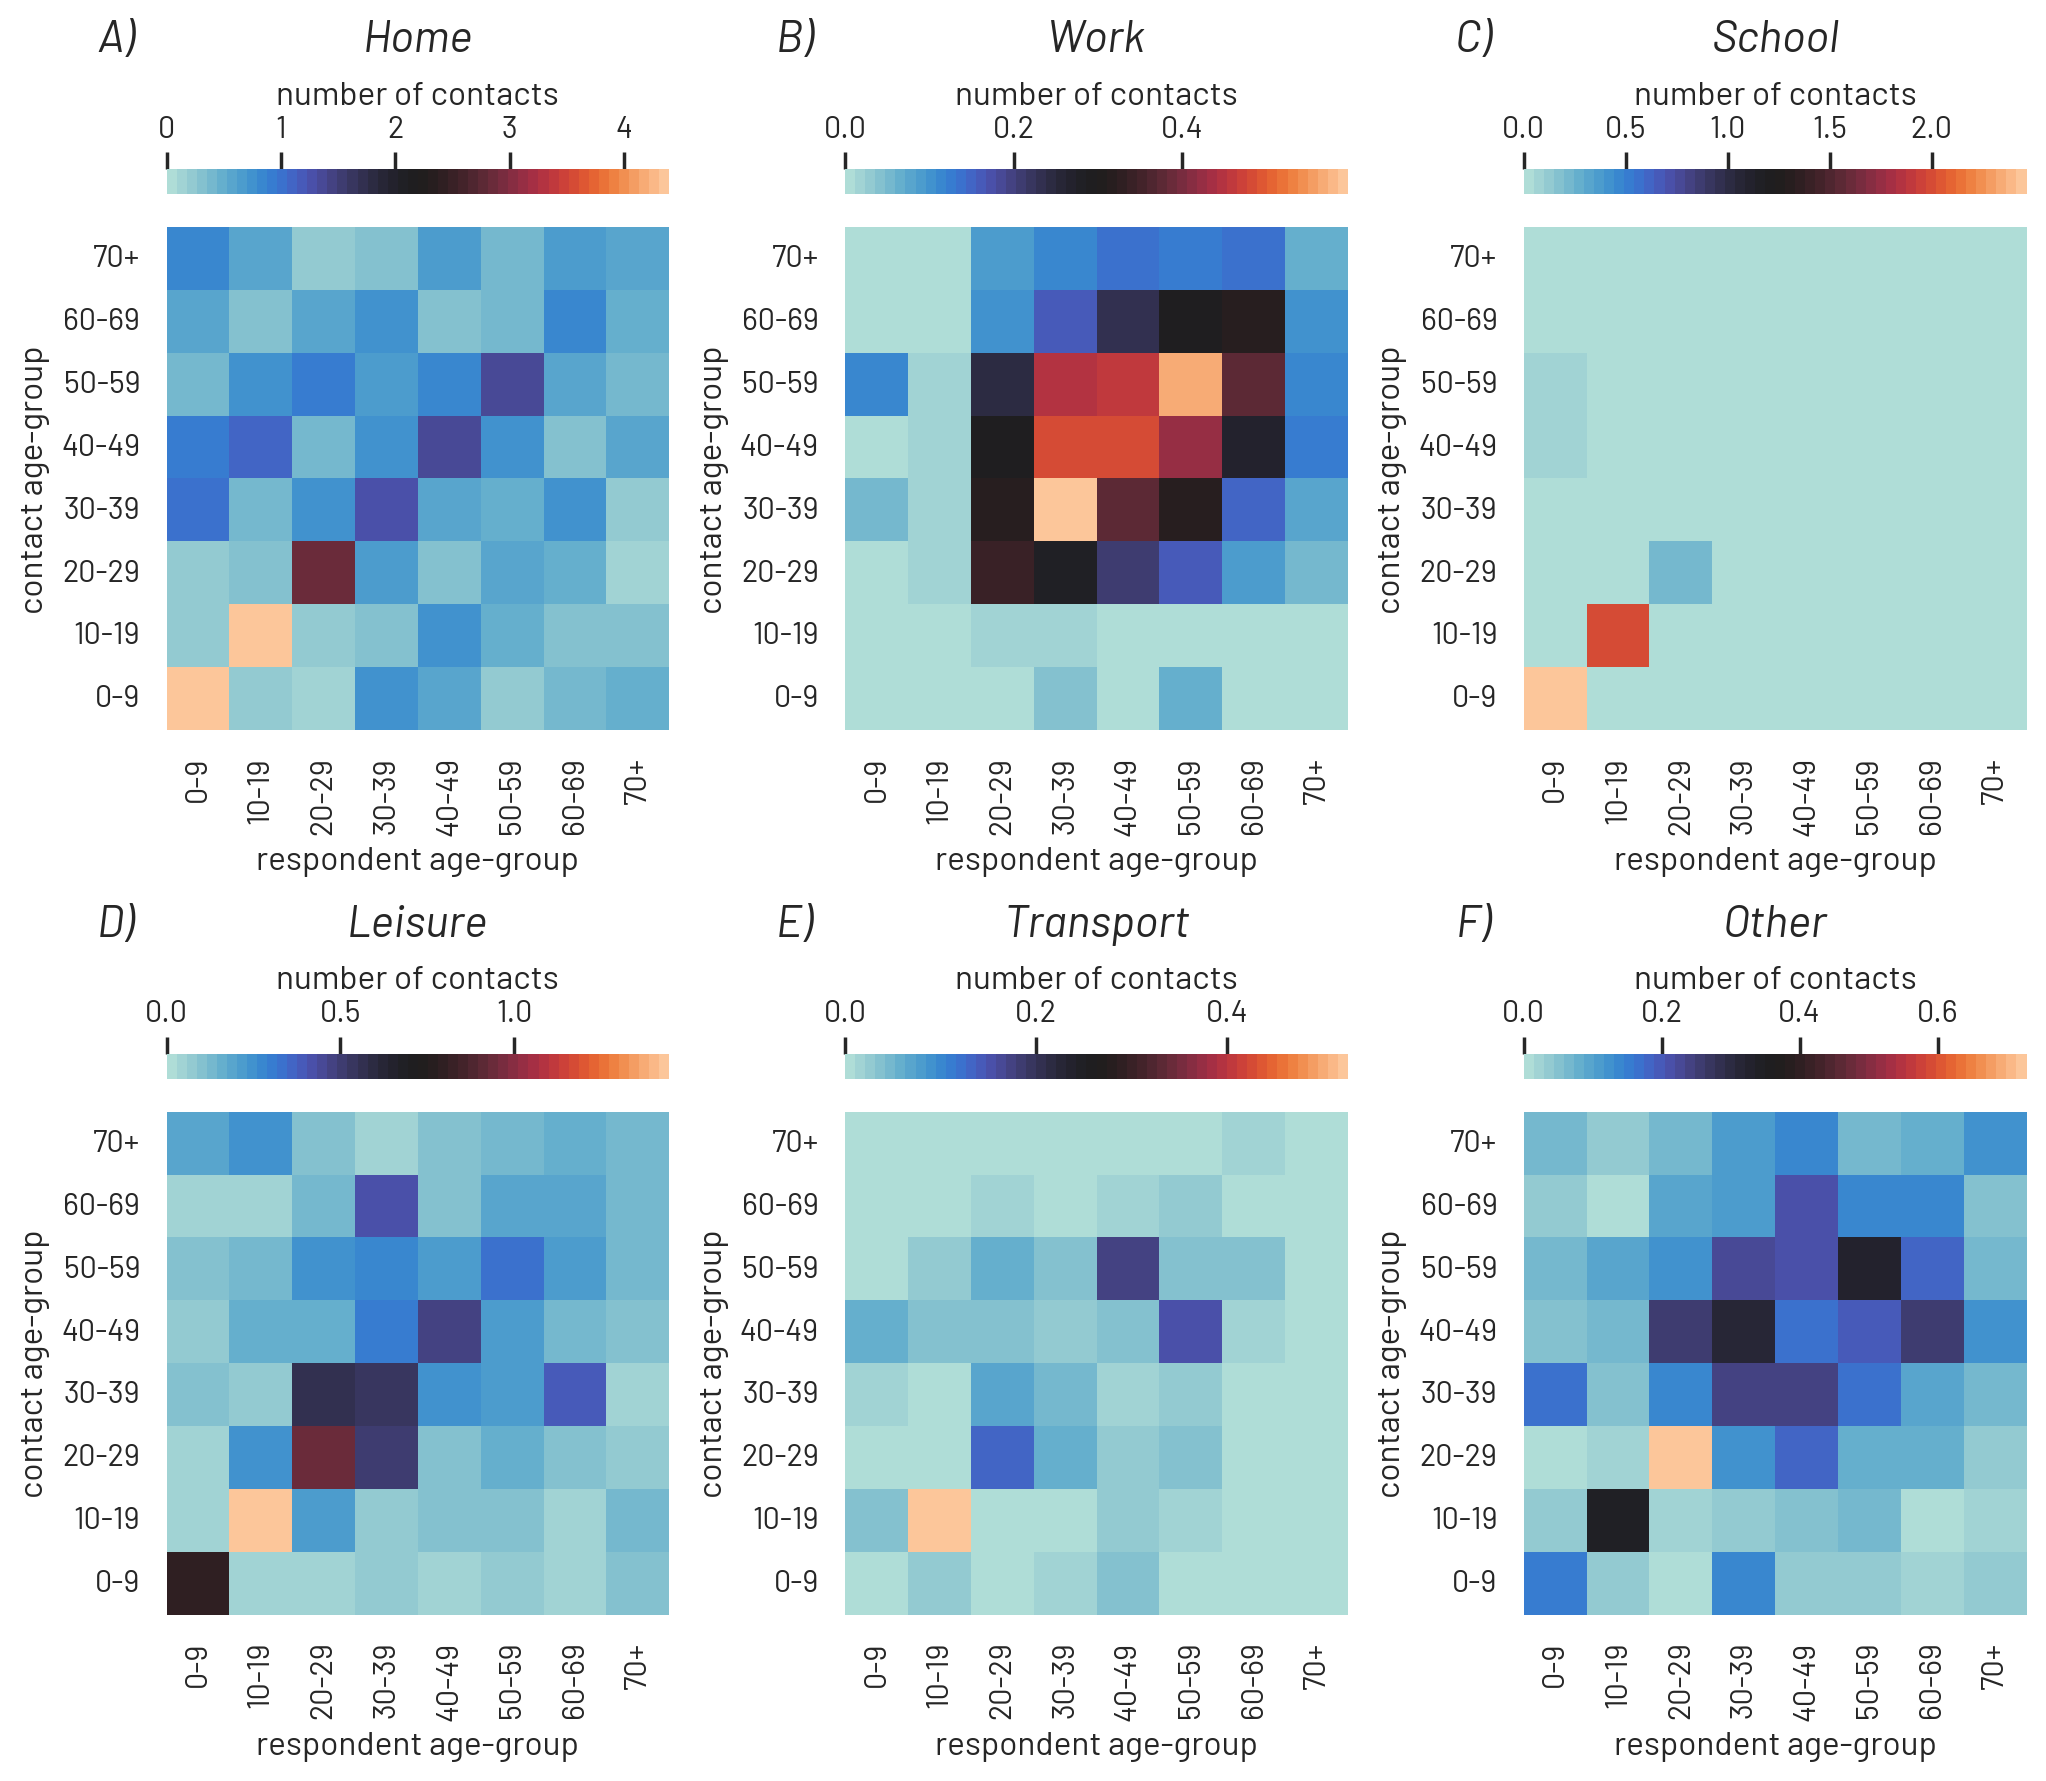

In [33]:
#######################################################################
#######################################################################
# Compute c. mat. from rinfo and contacts for subsample of population #
#######################################################################
#### Set "attendance" to "True" to get "in presence" work/school matrices, set to "False" to get "remote/not-in-person/no workers" matrices
# If "attendance is None" get total matrices
attendance = True
if attendance: suffix = 'In-person'
else:          suffix = 'Not-in-person'
#######################################################################
subset_group = None
subset_value = None
sens=12
round_notes = 1

#### Select target respondent and their contacts
if group_pop not in respondentToPlot.columns:
    respondentToPlot[group_pop] = respondentToPlot[group_col].map(contactToPlot[[group_col,group_pop]].drop_duplicates().set_index(group_col).to_dict()[group_pop])
######## Select subset of respondents ! ########
if not attendance is None: rsi_all = respondentToPlot[(respondentToPlot['attendance']==attendance)].copy()  
else:                      rsi_all = respondentToPlot.copy()
################################################
cts_all = contactToPlot[contactToPlot['part_id'].isin(rsi_all['part_id'])].copy()
index_pop = respondentToPlot.drop_duplicates(group_col).sort_values(order_col).set_index(group_col)[group_pop].to_dict()
group_loc = contactToPlot[[group_col,order_col,group_pop]].dropna().drop_duplicates().sort_values(order_col).loc[:,group_col].dropna().unique()

################################################
################ FIGURE drawing ################
fig2, axs = plt.subplot_mosaic([['Home','Work','School'],['Leisure','Transport','Other']],figsize=(12,10))
plt.subplots_adjust(wspace=.35,hspace=0.4)
for ii,loc in enumerate(['Home','Work','School','Leisure','Transport','Other']):
    print(f'\n{loc}')
    rsi = rsi_all.copy() # whatever respondent...entire data or any subset
    cts = cts_all[cts_all['part_id'].isin(rsi['part_id'].tolist())].copy()
    cts['cont_id'] = cts[['location_multi','cont_id']].apply(lambda x: nan_col(x,loc,'location_multi'), axis=1)
    # compute reciprocal and return avg.contacts per group_col and bootstrap
    q, m = bootstrap_contact_matrices(rsi_all, rsi, cts, group_col, group_pop, order_col, bootstrap=bootstrap_iterations, 
                                      bootstrap_dir=f'{savedir}bootstrap_age_group{"_"+str(age_groups) if age_groups !=5 else ""}_{loc.lower()}_{attendance_suffix_name[attendance]}/', index_NA=index_pop)
    ### averaging Qs and average contacts for each bootstrap iteration
    q1g = pd.concat([q[coli] for coli in q.columns])
    dsx1 = pd.concat([pd.DataFrame(index=m[0].index,columns=m[0].columns, data=mi).sum() for mi in m])
    ### Averaging bootstrapped matrices
    tmp1 = pd.DataFrame(index=m[0].index,columns=m[0].columns, data=np.nanmean(np.array([mi.values for mi in m]),0))
    c_lims[loc] = (0,max(tmp1.max().max(),c_lims[loc][1]))
    ###################################
    ######### FIGURE drawing ##########
    ###################################
    axs[loc] = plot_contact_matrix(tmp1, q1g, dsx1, loc, Q=False, 
                                   A_ylims=A_ylims, 
                                   annotations=False, square=True, matrix_only=True, 
                                   axs=[axs[loc]])
    axs[loc].text(x=-.1,y=1.35, s=['A)','B)','C)','D)','E)','F)'][ii], fontweight ='normal', fontstyle='italic', fontsize=16, transform=axs[loc].transAxes, horizontalalignment='center')
    axs[loc].text(x=.5,y=1.35, s=loc, fontweight ='normal', fontstyle='italic', fontsize=16, transform=axs[loc].transAxes, horizontalalignment='center')

fig2.savefig(f'figures_out/SIfigure7_cmat_age_group{"_"+str(age_groups) if age_groups !=5 else ""}_by_setting_{attendance_suffix_name[attendance]}.pdf', bbox_inches='tight')



Home
Bootstrapping ... 1000 / 1000	
Work
Bootstrapping ... 1000 / 1000	
School
Bootstrapping ... 1000 / 1000	
Leisure
Bootstrapping ... 1000 / 1000	
Transport
Bootstrapping ... 1000 / 1000	
Other
Bootstrapping ... 1000 / 1000	

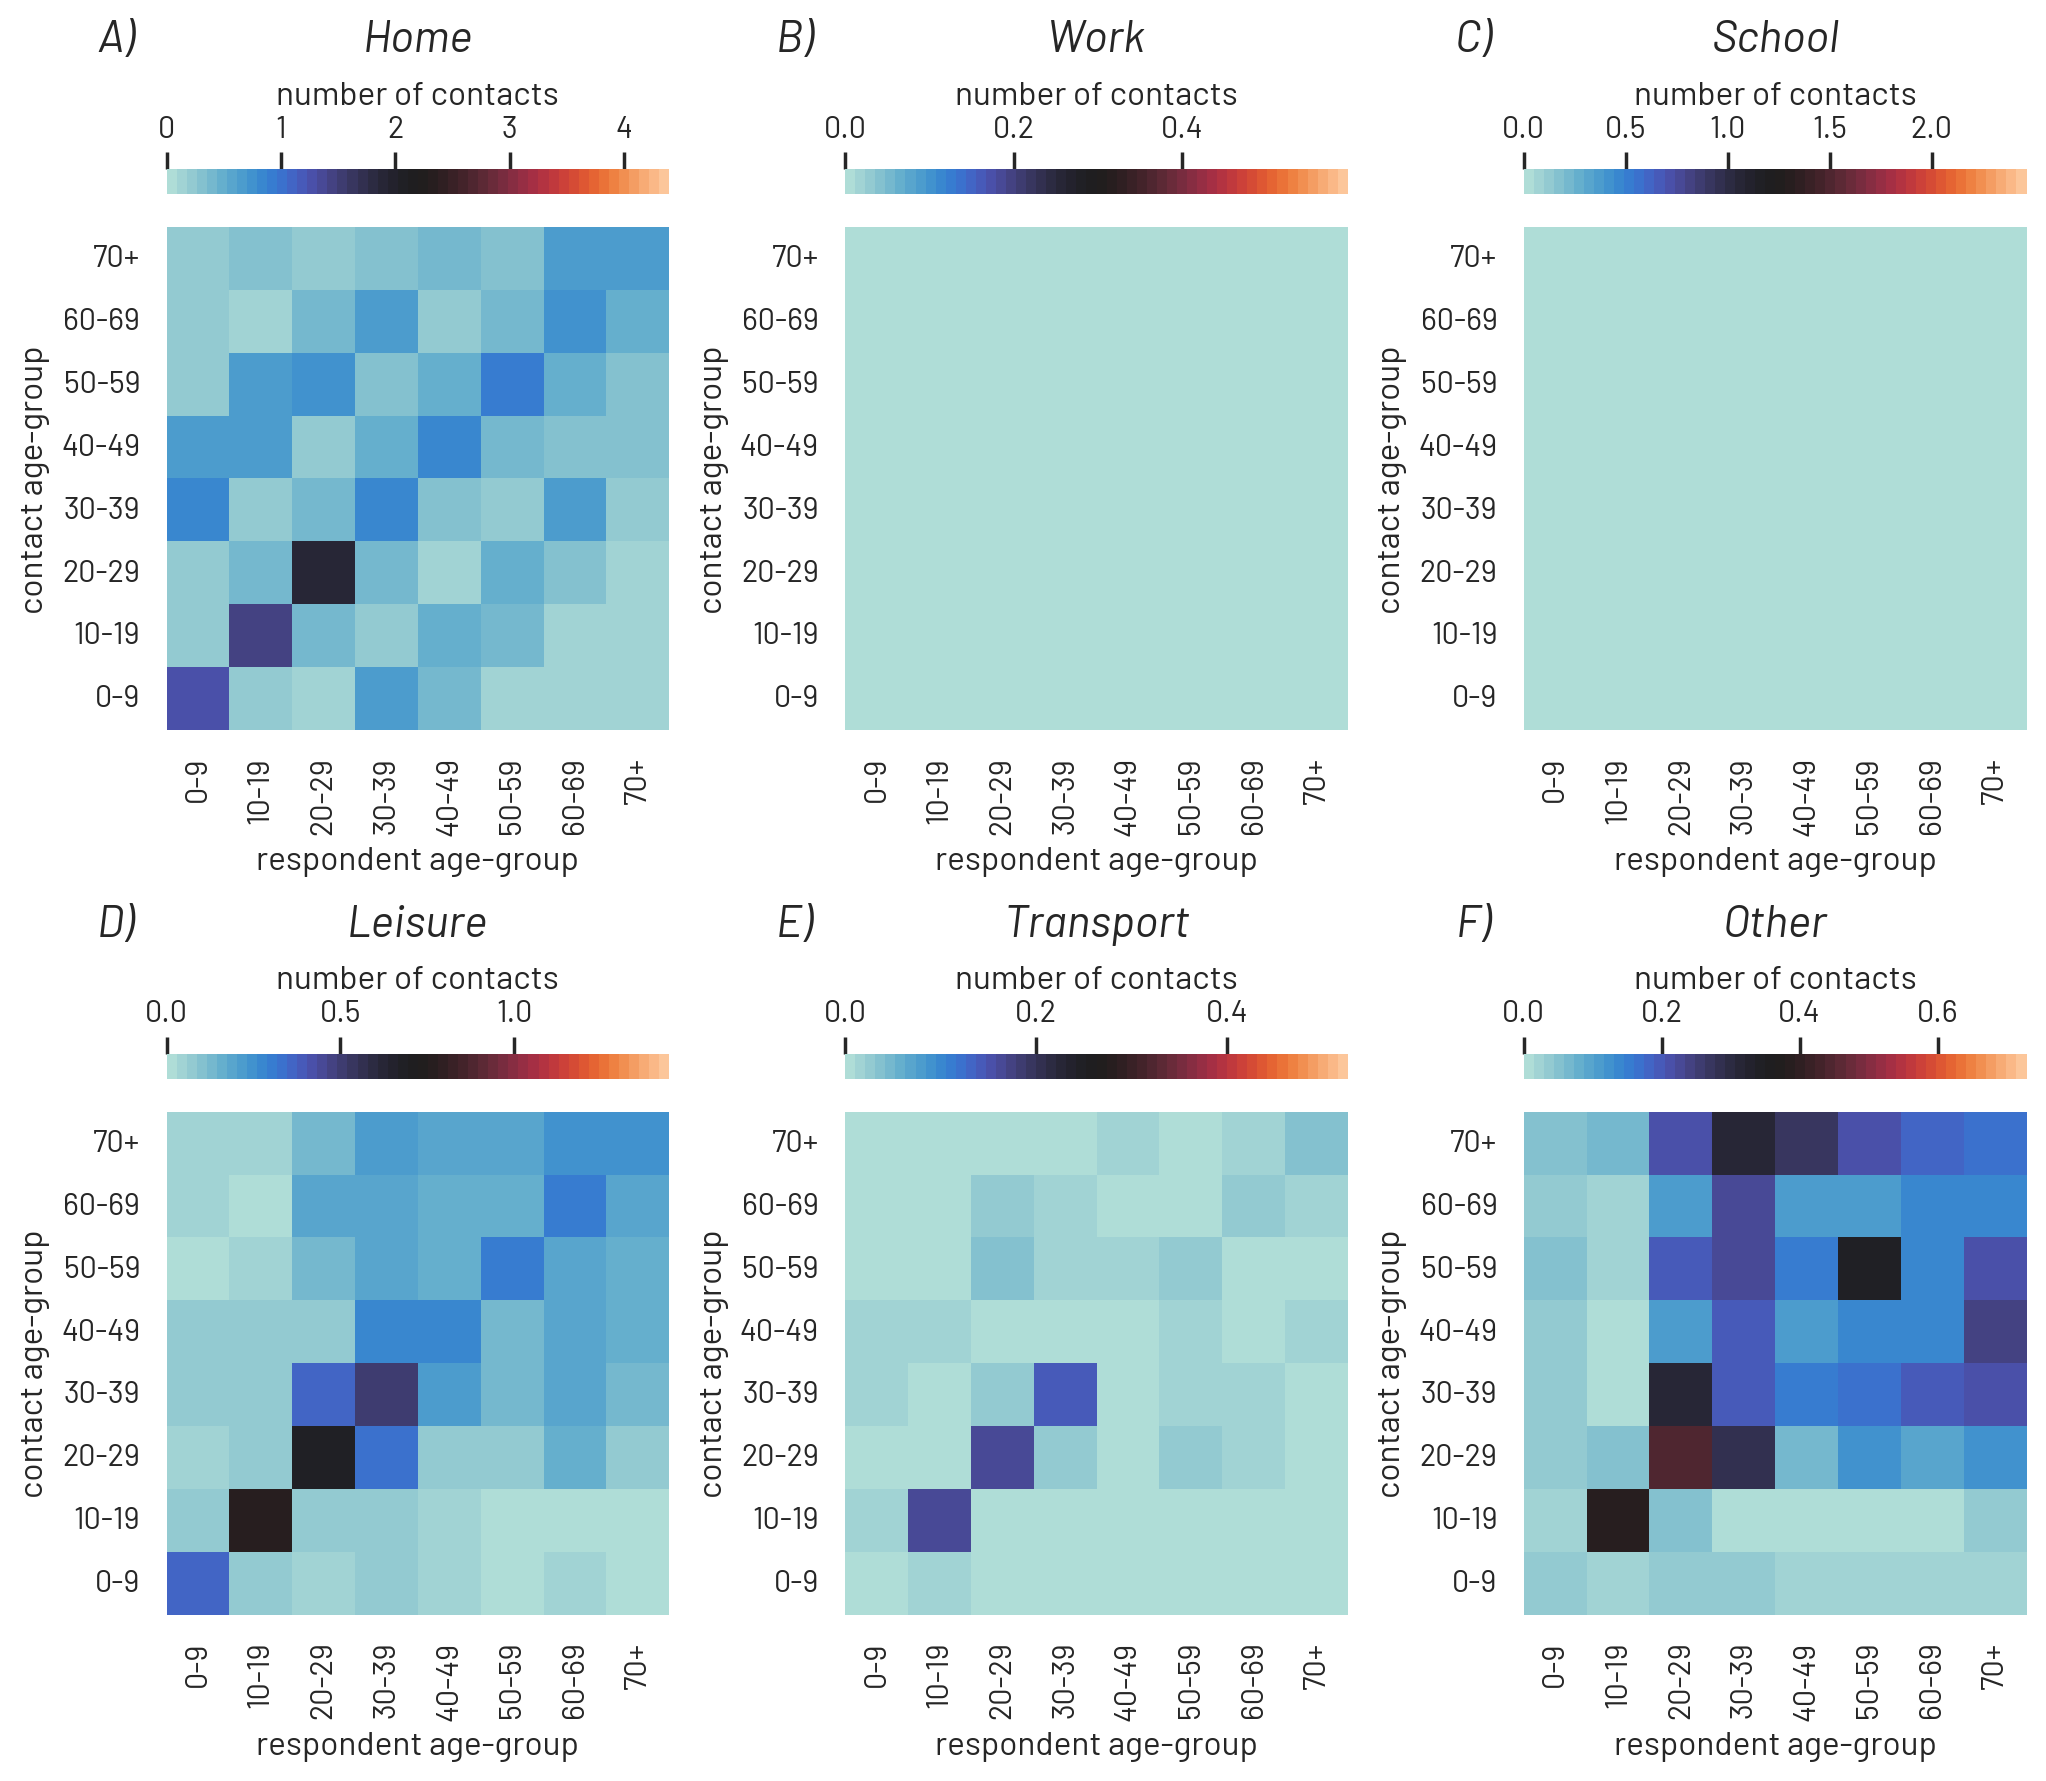

In [34]:
#######################################################################
#######################################################################
# Compute c. mat. from rinfo and contacts for subsample of population #
#######################################################################
#### Set "attendance" to "True" to get "in presence" work/school matrices, set to "False" to get "remote/not-in-person/no workers" matrices
# If "attendance is None" get total matrices
attendance = False
if attendance: suffix = 'In-person'
else:          suffix = 'Not-in-person'
#######################################################################
subset_group = None
subset_value = None
sens=12
round_notes = 1

#### Select target respondent and their contacts
if group_pop not in respondentToPlot.columns:
    respondentToPlot[group_pop] = respondentToPlot[group_col].map(contactToPlot[[group_col,group_pop]].drop_duplicates().set_index(group_col).to_dict()[group_pop])
######## Select subset of respondents ! ########
if not attendance is None: rsi_all = respondentToPlot[(respondentToPlot['attendance']==attendance)].copy()  
else:                      rsi_all = respondentToPlot.copy()
################################################
cts_all = contactToPlot[contactToPlot['part_id'].isin(rsi_all['part_id'])].copy()
index_pop = respondentToPlot.drop_duplicates(group_col).sort_values(order_col).set_index(group_col)[group_pop].to_dict()
group_loc = contactToPlot[[group_col,order_col,group_pop]].dropna().drop_duplicates().sort_values(order_col).loc[:,group_col].dropna().unique()

################################################
################ FIGURE drawing ################
fig3, axs = plt.subplot_mosaic([['Home','Work','School'],['Leisure','Transport','Other']],figsize=(12,10))
plt.subplots_adjust(wspace=.35,hspace=0.4)

for ii,loc in enumerate(['Home','Work','School','Leisure','Transport','Other']):
    print(f'\n{loc}')
    rsi = rsi_all.copy() # whatever respondent...entire data or any subset
    cts = cts_all[cts_all['part_id'].isin(rsi['part_id'].tolist())].copy()
    cts['cont_id'] = cts[['location_multi','cont_id']].apply(lambda x: nan_col(x,loc,'location_multi'), axis=1)
    # compute reciprocal and return avg.contacts per group_col and bootstrap
    q, m = bootstrap_contact_matrices(rsi_all, rsi, cts, group_col, group_pop, order_col, bootstrap=bootstrap_iterations, 
                                      bootstrap_dir=f'{savedir}bootstrap_age_group{"_"+str(age_groups) if age_groups !=5 else ""}_{loc.lower()}_{attendance_suffix_name[attendance]}/', index_NA=index_pop)
    ### averaging Qs and average contacts for each bootstrap iteration
    q1g = pd.concat([q[coli] for coli in q.columns])
    dsx2 = pd.concat([pd.DataFrame(index=m[0].index,columns=m[0].columns, data=mi).sum() for mi in m])
    ### Averaging bootstrapped matrices
    tmp2 = pd.DataFrame(index=m[0].index,columns=m[0].columns, data=np.nanmean(np.array([mi.values for mi in m]),0))
    c_lims[loc] = (0,max(tmp2.max().max(),c_lims[loc][1]))
    ###################################
    ######### FIGURE drawing ##########
    ###################################
    axs[loc] = plot_contact_matrix(tmp2, q1g, dsx2, loc, Q=False, 
                                   A_ylims=A_ylims, C_lims=c_lims[loc],
                                   annotations=False, square=True, matrix_only=True, 
                                   axs=[axs[loc]])
    axs[loc].text(x=-.1,y=1.35, s=['A)','B)','C)','D)','E)','F)'][ii], fontweight ='normal', fontstyle='italic', fontsize=16, transform=axs[loc].transAxes, horizontalalignment='center')
    axs[loc].text(x=.5,y=1.35, s=loc, fontweight ='normal', fontstyle='italic', fontsize=16, transform=axs[loc].transAxes, horizontalalignment='center')

fig3.savefig(f'figures_out/SIfigure8_cmat_age_group{"_"+str(age_groups) if age_groups !=5 else ""}_by_setting_{attendance_suffix_name[attendance]}.pdf', bbox_inches='tight')


### By wave overall differences

In [36]:
### Load data
###########################
savedir = 'data_out/matrices/bootstrap/'
A_ylims = [(-.01,0.75),(-0.5,18.5)]

# Select which age groups to use (NOTE: specific contacts and respondent data will be loaded, see cell below.)
bootstrap_iterations = b_iter = 1000
age_groups = 5

###########################
# Loading Italian population data as of January 2022
ag = pd.read_csv('data_in/age_gender.csv')
ag['age'] = ag['Età'].apply(lambda x: x.split(' ')[0])
ag = ag[(ag['Sesso']=='totale')&(ag['age']!='totale')&(ag['Territorio']=='Italia')]
ag = ag.groupby('age')['Value'].sum().reset_index()
ag = ag.astype({'age':int, 'Value':int}).sort_values('age').reset_index(drop=True)
ag[f'pop_{age_groups}'] = pd.cut(ag['age'], 
                                 bins=[i for i in range(0,75,age_groups)]+[150], 
                                 labels=[f'{i}-{i+age_groups-1}' for i in range(0,70,age_groups)]+['70+'], 
                                 right=True, include_lowest=True)
population_vector = ag.groupby(f'pop_{age_groups}', observed=False)['Value'].sum()

########################################################################
### Selecting contacts and respondents of interest 
########################################################################
order_col = 'part_age'
group_col = f'part_age_group_{age_groups}'     # selected age_group of interest
group_pop = f'part_age_group_pop_{age_groups}' # population vector mapped to each respondent age_group

# Load respondents' and contacts' data
sd = pd.read_csv(f'data_out/MixIT/sday_MixIT_2022_2023.csv')
cs = pd.read_csv(f"data_out/contacts_prol_prop_{age_groups}y_agegroups.csv")
ri = pd.read_csv(f"data_out/participants_rich_{age_groups}y_agegroups.csv")
ri = ri.merge(sd, on=['part_id'])
ri['attendance'] = ri['presence_work'].map({'In-person work': True, np.nan:False, 'No work':False, 'Remote work':False}) | ri['presence_school'].map({'In-person attendance': True, np.nan:False, 'No attendance':False, 'Remote attendance':False})

ri[f'part_age_group_pop_{age_groups}'] = ri[f'part_age_group_{age_groups}'].map(population_vector.to_dict())
cs[f'part_age_group_pop_{age_groups}'] = cs[f'part_age_group_{age_groups}'].map(population_vector.to_dict())
cs[f'cnt_age_group_pop_{age_groups}'] = cs[f'cnt_age_group_{age_groups}'].map(population_vector.to_dict())

##############################
ticklabelssize=8
annotlabelsize=6
subset_group = None
subset_value = None
sens=12
round_notes = 1

##############################
#### MATRICES JOINT WAVES ####
##############################
contactToPlot = cs[cs['is_soft']!=True].copy() # The number of contacts an individual had is computed as the non-overlapping sum of the direct contacts and the indirect contacts minus the indoor direct contacts
contactToPlot = contactToPlot.merge(ri[['part_id']],on='part_id', how='right')
respondentToPlot = ri.copy()
index_pop = respondentToPlot.drop_duplicates(group_col).sort_values(order_col).set_index(group_col)[group_pop].to_dict()
group_loc = contactToPlot[[group_col,order_col,group_pop]].dropna().drop_duplicates().sort_values(order_col).loc[:,group_col].dropna().unique()

####    INPUT Overall    #####
q, m = bootstrap_contact_matrices(respondentToPlot, respondentToPlot, contactToPlot, group_col, group_pop, order_col, bootstrap=b_iter, save_bootstraps=False, index_NA=index_pop)
q1g0 = pd.concat([q[coli] for coli in q.columns])
dsx10 = pd.concat([pd.DataFrame(index=m[0].index,columns=m[0].columns, data=mi).sum() for mi in m])
tmp10 = pd.DataFrame(index=m[0].index,columns=m[0].columns, data=np.array([mi.values for mi in m]).mean(0))
input_A0 = [tmp10.copy(), q1g0.copy(), dsx10.copy()]
##############################
####   INPUT inPresence   ####
attendance = True
if attendance: suffix = 'In-person'
else:          suffix = 'Not-in-person'
rsi = respondentToPlot[(respondentToPlot['attendance']==attendance)].copy()  
cts = contactToPlot[contactToPlot['part_id'].isin(rsi['part_id'])].copy()

gl = cts[[group_col,order_col,group_pop]].dropna().drop_duplicates().sort_values(order_col).loc[:,group_col].dropna().unique()
q, m = bootstrap_contact_matrices(respondentToPlot,rsi, cts, group_col, group_pop, order_col, bootstrap=b_iter, save_bootstraps=False, index_NA=index_pop)
q1g0 = pd.concat([q[coli] for coli in q.columns]).loc[gl]
dsx10 = pd.concat([pd.DataFrame(index=m[0].index,columns=m[0].columns, data=mi).sum() for mi in m]).loc[gl]
tmp10 = pd.DataFrame(index=m[0].index,columns=m[0].columns, data=np.array([mi.values for mi in m]).mean(0))
input_B0 = [tmp10.copy(), q1g0.copy(), dsx10.copy()]
##############################
#### INPUT NOT inPresence ####
attendance = False
if attendance: suffix = 'In-person'
else:          suffix = 'Not-in-person'
rsi = respondentToPlot[(respondentToPlot['attendance']==attendance)].copy()  
cts = contactToPlot[contactToPlot['part_id'].isin(rsi['part_id'])].copy()

gl = cts[[group_col,order_col,group_pop]].dropna().drop_duplicates().sort_values(order_col).loc[:,group_col].dropna().unique()
q, m = bootstrap_contact_matrices(respondentToPlot,rsi, cts, group_col, group_pop, order_col, bootstrap=b_iter, save_bootstraps=False, index_NA=index_pop)
q1g0 = pd.concat([q[coli] for coli in q.columns]).loc[gl]
dsx10 = pd.concat([pd.DataFrame(index=m[0].index,columns=m[0].columns, data=mi).sum() for mi in m]).loc[gl]
tmp10 = pd.DataFrame(index=m[0].index,columns=m[0].columns, data=np.array([mi.values for mi in m]).mean(0))
input_C0 = [tmp10.copy(), q1g0.copy(), dsx10.copy()]
##############################
##############################


##############################
#### MATRICES WAVE 2 only ####
##############################
rw2 = respondentToPlot[respondentToPlot['wave']==2].copy()
cw2 = contactToPlot[contactToPlot['part_id'].isin(rw2['part_id'].tolist())].copy()

##############################
####    INPUT Overall    #####
q, m = bootstrap_contact_matrices(rw2, rw2, cw2, group_col, group_pop, order_col, bootstrap=b_iter, save_bootstraps=False, index_NA=index_pop)
q1g2 = pd.concat([q[coli] for coli in q.columns])
dsx12 = pd.concat([pd.DataFrame(index=m[0].index,columns=m[0].columns, data=mi).sum() for mi in m])
tmp12 = pd.DataFrame(index=m[0].index,columns=m[0].columns, data=np.array([mi.values for mi in m]).mean(0))
input_A2 = [tmp12.copy(), q1g2.copy(), dsx12.copy()]
##############################
####   INPUT inPresence   ####
attendance = True
if attendance: suffix = 'In-person'
else:          suffix = 'Not-in-person'
rsi = rw2[(rw2['attendance']==attendance)].copy()  
cts = cw2[cw2['part_id'].isin(rsi['part_id'])].copy()

gl = cts[[group_col,order_col,group_pop]].dropna().drop_duplicates().sort_values(order_col).loc[:,group_col].dropna().unique()
q, m = bootstrap_contact_matrices(rsi,rsi, cts, group_col, group_pop, order_col, bootstrap=b_iter, save_bootstraps=False, index_NA=index_pop)
q1g2 = pd.concat([q[coli] for coli in q.columns]).loc[gl]
dsx12 = pd.concat([pd.DataFrame(index=m[0].index,columns=m[0].columns, data=mi).sum() for mi in m]).loc[gl]
tmp12 = pd.DataFrame(index=m[0].index,columns=m[0].columns, data=np.array([mi.values for mi in m]).mean(0))
input_B2 = [tmp12.copy(), q1g2.copy(), dsx12.copy()]
##############################
#### INPUT NOT inPresence ####
attendance = False
if attendance: suffix = 'In-person'
else:          suffix = 'Not-in-person'
rsi = rw2[(rw2['attendance']==attendance)].copy()  
cts = cw2[cw2['part_id'].isin(rsi['part_id'])].copy()

gl = cts[[group_col,order_col,group_pop]].dropna().drop_duplicates().sort_values(order_col).loc[:,group_col].dropna().unique()
q, m = bootstrap_contact_matrices(rsi,rsi, cts, group_col, group_pop, order_col, bootstrap=b_iter, save_bootstraps=False, index_NA=index_pop)
q1g2 = pd.concat([q[coli] for coli in q.columns]).loc[gl]
dsx12 = pd.concat([pd.DataFrame(index=m[0].index,columns=m[0].columns, data=mi).sum() for mi in m]).loc[gl]
tmp12 = pd.DataFrame(index=m[0].index,columns=m[0].columns, data=np.array([mi.values for mi in m]).mean(0))
input_C2 = [tmp12.copy(), q1g2.copy(), dsx12.copy()]


Bootstrapping ... 1000 / 1000	

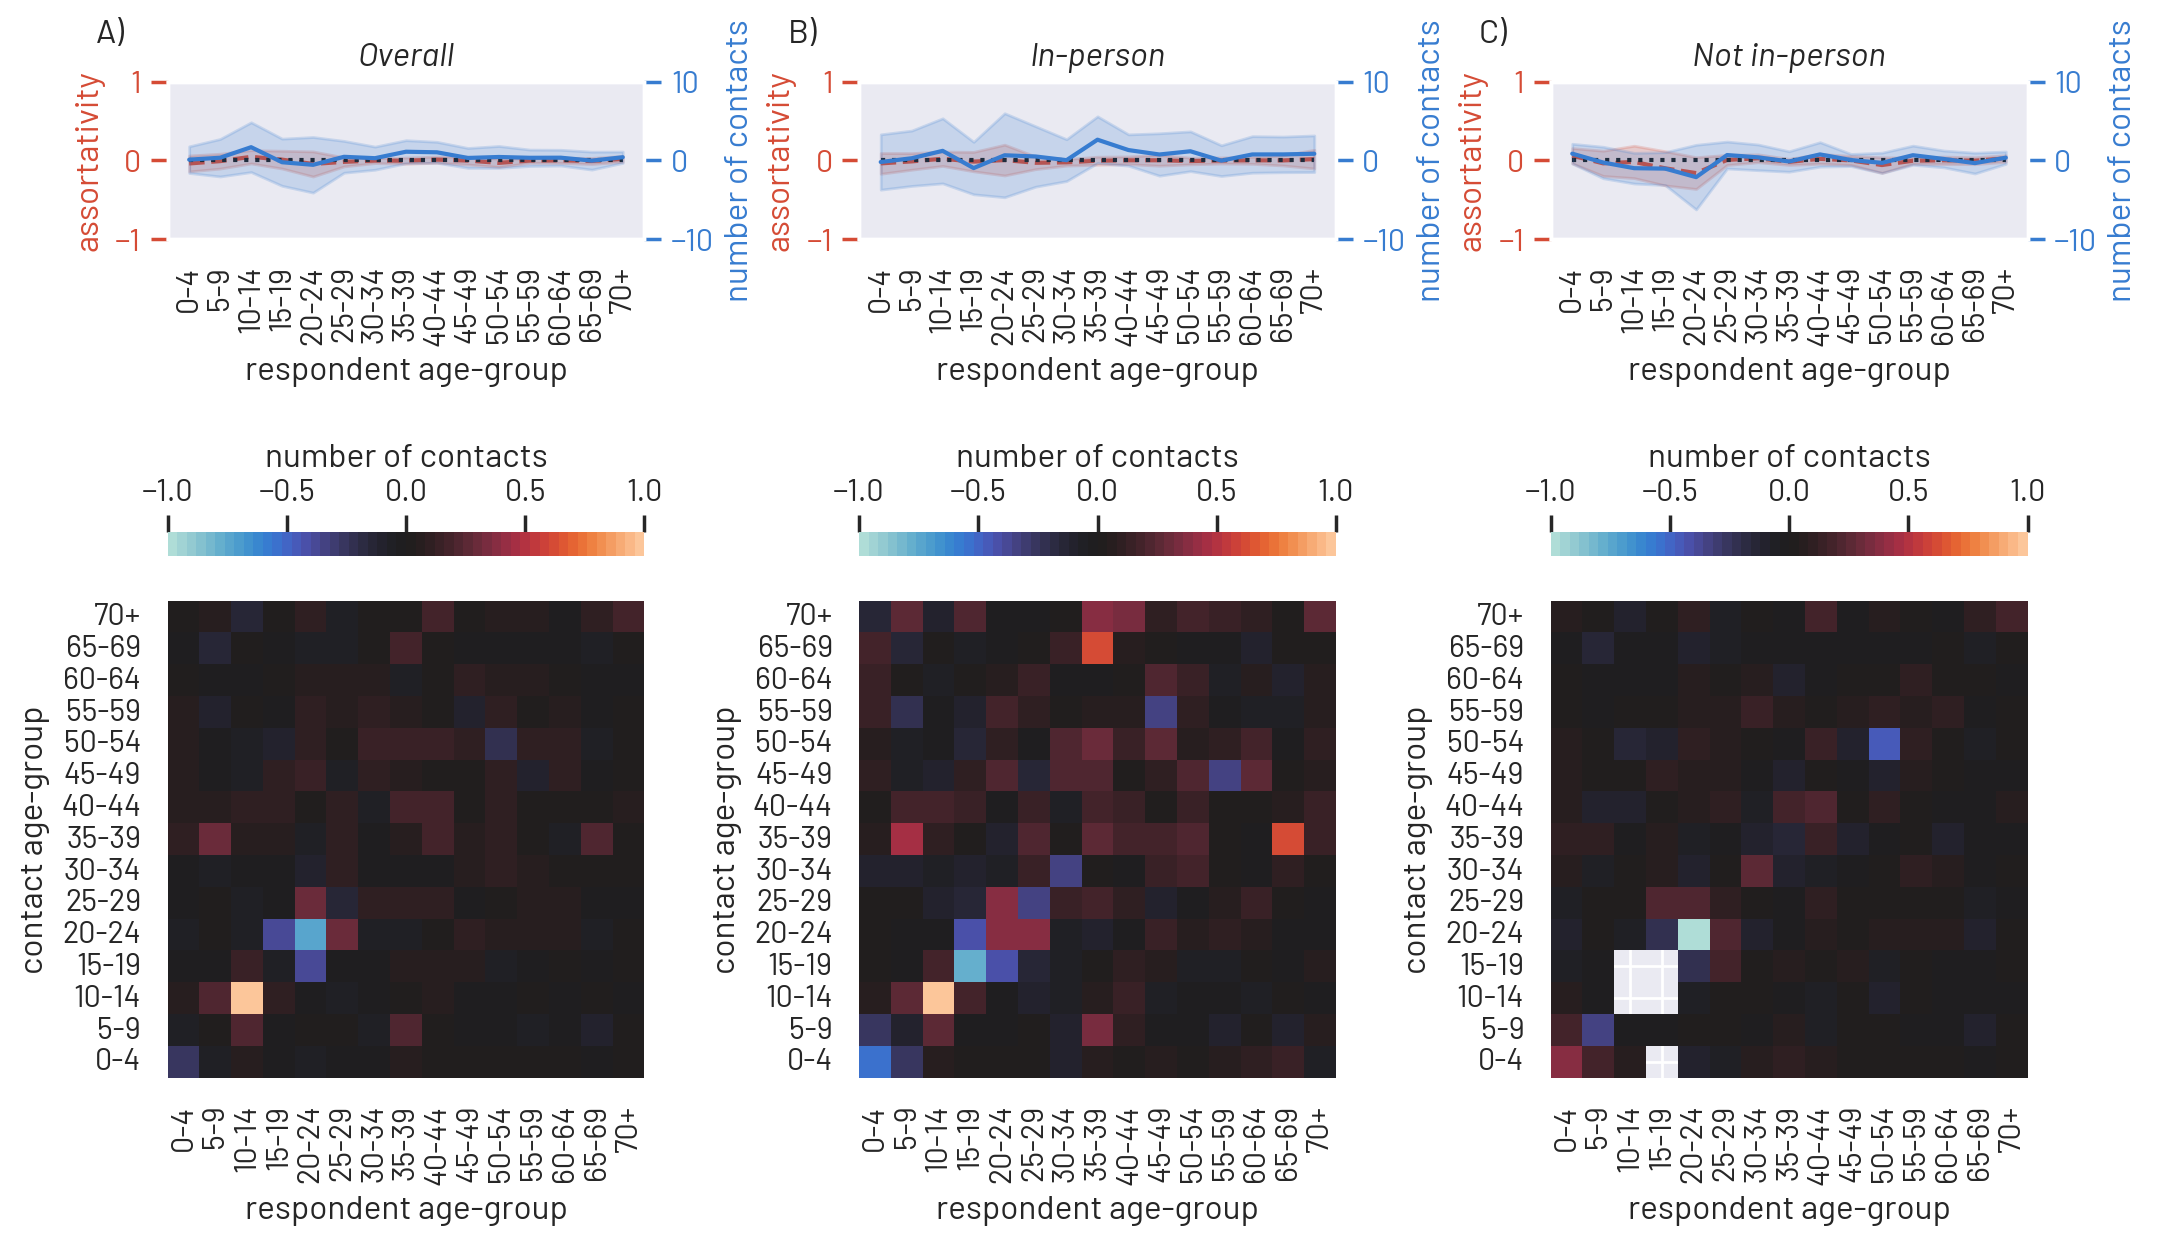

In [37]:

######### FIGURE drawing ##########
fig, ax = plt.subplot_mosaic([['ADup','BDup','CDup'],['AD','BD','CD']], height_ratios=[0.15,0.85], figsize=(12,8))
cmap = sns.color_palette("icefire", 50)[:]


plot_contact_matrix((input_A2[0]-input_A0[0]), input_A2[1]-input_A0[1], input_A2[2]-input_A0[2], annotations=False, square=True, Q=False, cbar_loc='top',
                    A_ylims=[(-1,1),(-10,10)], C_lims=(-1.,1.), axs=[ax['ADup'],ax['AD']], fig_title='Overall')
plot_contact_matrix((input_B2[0]-input_B0[0]), input_B2[1]-input_B0[1], input_B2[2]-input_B0[2], annotations=False, square=True, Q=False, cbar_loc='top',
                    A_ylims=[(-1,1),(-10,10)], C_lims=(-1.,1.), axs=[ax['BDup'],ax['BD']], fig_title='In-person')
plot_contact_matrix((input_C2[0]-input_C0[0]), input_C2[1]-input_C0[1], input_C2[2]-input_C0[2], annotations=False, square=True, Q=False, cbar_loc='top',
                    A_ylims=[(-1,1),(-10,10)], C_lims=(-1.,1.), axs=[ax['CDup'],ax['CD']], fig_title='Not in-person')

ax['ADup'].text(s='A)',x=-.15,y=1.25, transform=ax['ADup'].transAxes)
ax['BDup'].text(s='B)',x=-.15,y=1.25, transform=ax['BDup'].transAxes)
ax['CDup'].text(s='C)',x=-.15,y=1.25, transform=ax['CDup'].transAxes)
ax['ADup'].hlines(0,0,len(input_A0[0])-1, ls=':',color='k', zorder=5)
ax['BDup'].hlines(0,0,len(input_B0[0])-1, ls=':',color='k', zorder=5)
ax['CDup'].hlines(0,0,len(input_C0[0])-1, ls=':',color='k', zorder=5)

plt.subplots_adjust(wspace=0.45,hspace=0.35)

fig.savefig('figures_out/SIfigure17_overall_inperson_notinperson_w2mean_diff.pdf', bbox_inches='tight')